In [56]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pymatgen.symmetry.groups import SpaceGroup
from tqdm.auto import tqdm  # For progress bar
import matplotlib.lines as mlines
import os

# Function to process variable-length descriptors into fixed-length representations
def process_descriptor(descriptor_series):
    """
    Process variable-length descriptors into fixed-length representations.

    Parameters:
    - descriptor_series (Series): Pandas Series containing descriptors (arrays of variable length).

    Returns:
    - features (ndarray): 2D numpy array of shape (n_samples, fixed_length)
    """
    # Initialize a list to store processed features
    processed_features = []
    for descriptor in descriptor_series:
        # Ensure the descriptor is a numpy array
        descriptor = np.array(descriptor)
        # Compute summary statistics
        mean = np.mean(descriptor)
        std = np.std(descriptor)
        min_val = np.min(descriptor)
        max_val = np.max(descriptor)
        # Concatenate the summary statistics into a fixed-length vector
        feature_vector = np.array([mean, std, min_val, max_val])
        processed_features.append(feature_vector)
    # Stack the processed features into a 2D array
    features = np.vstack(processed_features)
    return features

# Load parquet files and extract relevant features with detailed progress bars
def load_and_extract_features(file_list):
    """
    Load parquet files and extract relevant features.

    Parameters:
    - file_list (list): List of file paths to parquet files.

    Returns:
    - combined_df (DataFrame): Combined DataFrame with relevant features.
    """
    combined_data = []

    for file in tqdm(file_list, desc='Processing files'):
        # Read only necessary columns
        columns_to_read = [
            'descriptors.soap_gen',
            'descriptors.acsf_gen',
            'descriptors.xrd_gen.iq',
            'dataset_name',
            'spacegroup',
            'seq_len',
            'species',
            'cell_params.a',
            'cell_params.b',
            'cell_params.c',
            'cell_params.alpha',
            'cell_params.beta',
            'cell_params.gamma',
            'cell_params.gen_vol',
            'cell_params.implied_vol',
            'validity.formula',
            'validity.spacegroup',
            'validity.bond_length',
            'validity.site_multiplicity',
        ]
        df = pd.read_parquet(file, columns=columns_to_read)

        # Convert feature columns to numpy arrays using vectorized operations
        for col in ['descriptors.soap_gen', 'descriptors.acsf_gen', 'descriptors.xrd_gen.iq']:
            df[col] = df[col].apply(lambda x: np.array(x) if isinstance(x, list) else x)

        combined_data.append(df)

    try:
        combined_df = pd.concat(combined_data, ignore_index=True)
    except ValueError as e:
        print(f"Error concatenating data frames: {e}")
        return pd.DataFrame()  # Return an empty DataFrame if concatenation fails

    # Convert 'spacegroup' to integer numbers using precomputed mapping
    unique_spacegroups = combined_df['spacegroup'].unique()

    # Create a mapping from spacegroup symbols to integer numbers
    spacegroup_mapping = {}
    for sg in unique_spacegroups:
        try:
            spacegroup_mapping[sg] = SpaceGroup(sg).int_number
        except:
            spacegroup_mapping[sg] = np.nan

    # Map the 'spacegroup' column to integer numbers
    combined_df['spacegroup_int'] = combined_df['spacegroup'].map(spacegroup_mapping)

    return combined_df


# Function to get spacegroup integer number with exception handling
def get_spacegroup_int(sg):
    try:
        return SpaceGroup(sg).int_number
    except:
        return np.nan

# Extract individual feature matrices
def get_feature_matrices(df):
    """
    Extract individual feature matrices for SOAP, ACSF, XRD, and combined features.

    Parameters:
    - df (DataFrame): DataFrame containing feature columns.

    Returns:
    - feature_dict (dict): Dictionary containing individual and combined feature matrices.
    - filtered_df (DataFrame): DataFrame after filtering out NaN values.
    """
    # Filter out rows where any of the descriptor columns are None or NaN
    filtered_df = df.dropna(subset=['descriptors.soap_gen', 'descriptors.acsf_gen', 'descriptors.xrd_gen.iq'])

    if len(filtered_df) == 0:
        raise ValueError("No data left after filtering for NaN values.")

    # Process each descriptor column into fixed-length features
    soap_features_summary = process_descriptor(filtered_df['descriptors.soap_gen'])
    soap_features_full =  np.vstack(filtered_df['descriptors.soap_gen'].values)
    
    # For ACSF, get both summary features and full features
    acsf_features_summary = process_descriptor(filtered_df['descriptors.acsf_gen'])
    acsf_features_full = np.vstack(filtered_df['descriptors.acsf_gen'].values)

    # For XRD, get both summary features and full features
    xrd_features_summary = process_descriptor(filtered_df['descriptors.xrd_gen.iq'])
    xrd_features_full = np.vstack(filtered_df['descriptors.xrd_gen.iq'].values)

    print(f"SOAP summary features shape: {soap_features_summary.shape}")
    print(f"SOAP full features shape: {soap_features_full.shape}")
    print(f"ACSF summary features shape: {acsf_features_summary.shape}")
    print(f"ACSF full features shape: {acsf_features_full.shape}")
    print(f"XRD summary features shape: {xrd_features_summary.shape}")
    print(f"XRD full features shape: {xrd_features_full.shape}")

    # Concatenate summary features for combined features
    combined_features = np.hstack([soap_features_summary, acsf_features_summary, xrd_features_summary])

    feature_dict = {
        'SOAP_Summary': soap_features_summary,
        'SOAP_Full': soap_features_full,
        'ACSF_Summary': acsf_features_summary,
        'ACSF_Full': acsf_features_full,
        'XRD_Summary': xrd_features_summary,
        'XRD_Full': xrd_features_full,
        'Combined': combined_features
    }

    return feature_dict, filtered_df

# Perform dimensionality reduction (e.g., PCA)
def perform_dimensionality_reduction(features, n_components=2):
    """
    Perform dimensionality reduction on the feature matrix.

    Parameters:
    - features (ndarray): The feature matrix.
    - n_components (int): Number of components for PCA.

    Returns:
    - reduced_features (ndarray): Reduced feature matrix.
    - pca (PCA object): Trained PCA model.
    - scaler (StandardScaler object): Fitted scaler object.
    """
    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Apply PCA
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features_scaled)

    return reduced_features, pca, scaler

# Filter outliers in reduced features
def filter_outliers_on_reduced_features(reduced_features, method='zscore', thresh=3.0):
    """
    Filter outliers based on the reduced features.

    Parameters:
    - reduced_features (ndarray): Reduced feature matrix (e.g., PCA components).
    - method (str): Method to use for outlier detection ('zscore' or 'iqr').
    - thresh (float): Threshold for outlier detection.

    Returns:
    - mask (ndarray): Boolean mask indicating which samples to keep.
    """
    if method == 'zscore':
        from scipy.stats import zscore
        z_scores = np.abs(zscore(reduced_features))
        mask = (z_scores < thresh).all(axis=1)
    elif method == 'iqr':
        Q1 = np.percentile(reduced_features, 25, axis=0)
        Q3 = np.percentile(reduced_features, 75, axis=0)
        IQR = Q3 - Q1
        lower_bound = Q1 - thresh * IQR
        upper_bound = Q3 + thresh * IQR
        mask = np.all((reduced_features >= lower_bound) & (reduced_features <= upper_bound), axis=1)
    else:
        raise ValueError("Invalid method for outlier detection. Choose 'zscore' or 'iqr'.")

    return mask


In [66]:
# Visualization function
def visualize_samples(reduced_features_dict, df_filtered_dict, save_path=None, separate_descriptor_path=None):
    """
    Visualize the samples after dimensionality reduction.

    Parameters:
    - reduced_features_dict (dict): Dictionary of reduced feature matrices.
    - df_filtered_dict (dict): Dictionary of filtered DataFrames for each descriptor.
    - save_path (str, optional): File path to save the combined plot.
    - separate_descriptor_path (str, optional): Directory to save individual descriptor plots.
    """
    sns.set(style='whitegrid')
    descriptors = ['SOAP_Summary', 'SOAP_Full', 'ACSF_Summary', 'ACSF_Full', 'XRD_Summary', 'XRD_Full', 'Combined']

    # Adjust font sizes
    plt.rcParams.update({'font.size': 10})
    for idx, descriptor in enumerate(descriptors):

        reduced_features = reduced_features_dict[descriptor]
        df_filtered = df_filtered_dict[descriptor]

        # Create a DataFrame for plotting
        plot_df = pd.DataFrame({
            'PC1': reduced_features[:, 0],
            'PC2': reduced_features[:, 1],
            'Dataset': df_filtered['dataset_name'].values,
            'Spacegroup': df_filtered['spacegroup_int'].values,
            'Sequence Length': df_filtered['seq_len'].values
        })

        # Normalize the 'Spacegroup' data for the color mapping
        norm = plt.Normalize(plot_df['Spacegroup'].min(), plot_df['Spacegroup'].max())
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
        sm.set_array([])

        # Apply markers for 'Dataset'
        unique_datasets = plot_df['Dataset'].unique()
        markers = ['o', '^', 'D', 'v', 'P', '*', 's', 'h', '+']  # Extend as needed

        fig_descriptor, ax_descriptor = plt.subplots(figsize=(10, 8), dpi=300)
        for i, dataset in enumerate(unique_datasets):
            idxs = plot_df['Dataset'] == dataset
            ax_descriptor.scatter(
                plot_df.loc[idxs, 'PC1'],
                plot_df.loc[idxs, 'PC2'],
                marker=markers[i % len(markers)],
                edgecolor='k',
                alpha=0.7,
                label=dataset
            )

        ax_descriptor.set_title(f"{descriptor} Descriptor", fontsize=12)
        ax_descriptor.set_xlabel('Principal Component 1', fontsize=10)
        ax_descriptor.set_ylabel('Principal Component 2', fontsize=10)
        ax_descriptor.tick_params(axis='both', which='major', labelsize=8)
        ax_descriptor.grid(alpha=0.5)
        
        # Add legend with only 'Dataset'
        handles, labels = ax_descriptor.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax_descriptor.legend(by_label.values(), by_label.keys(), title='Dataset', fontsize=8)

        plt.show()

Processing files:   0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_23249/1886013083.py:59: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validity_data = df.loc[idxs, f'validity.{param}'].replace({None: False})


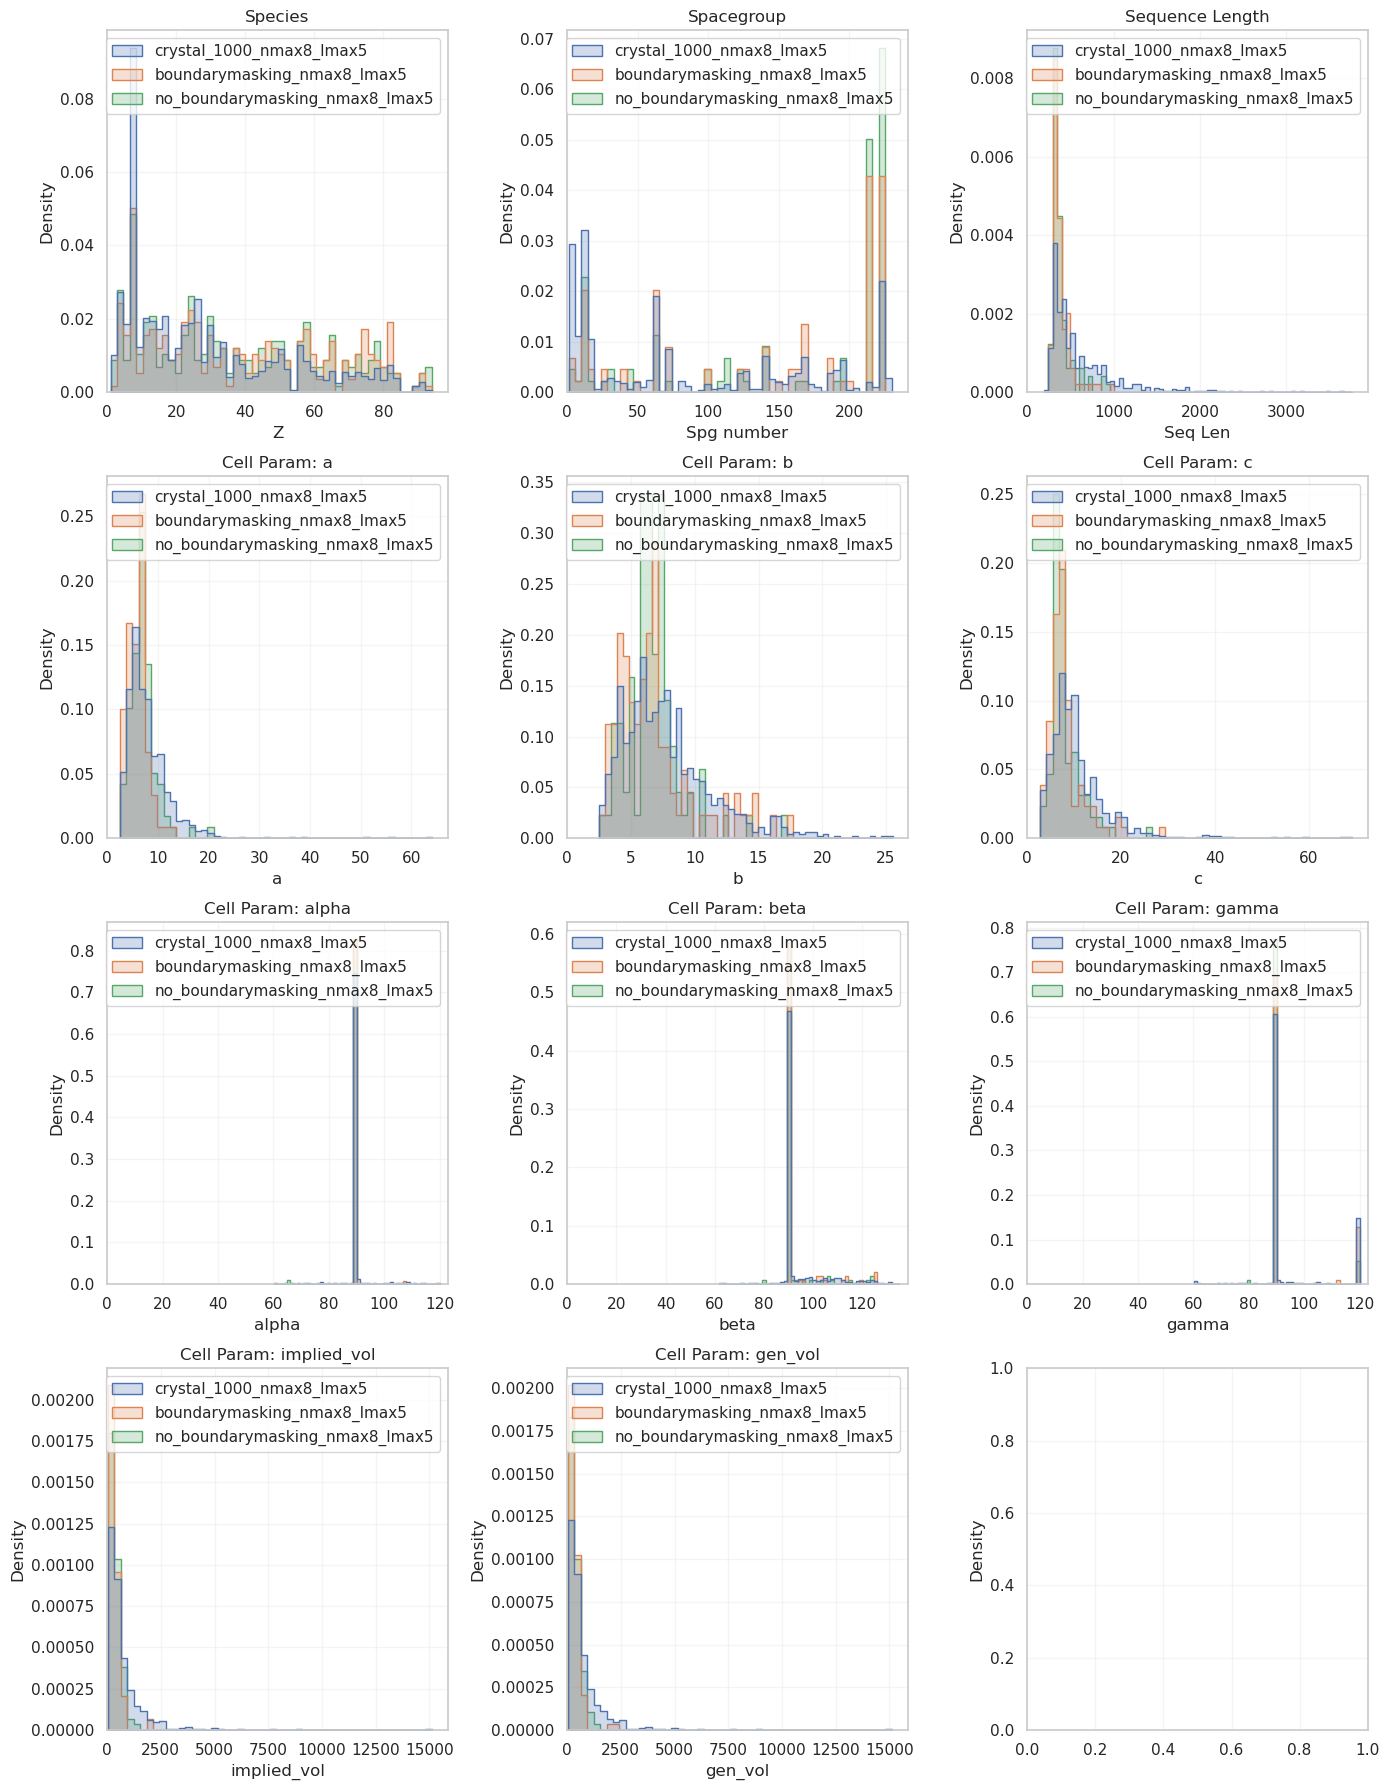

In [67]:
from pymatgen.core import Element
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Suppress only the RuntimeWarning from numpy
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Define file paths and options
file_list = [
    '../nomodel/crystal_1k/nmax8_lmax5/crystal_1000_nmax8_lmax5.eval',
    '../cross-contamination/deciferdataset_experiment/boundarymasking/boundarymasking_nmax8_lmax5.eval',
    '../cross-contamination/deciferdataset_experiment/no_boundarymasking/no_boundarymasking_nmax8_lmax5.eval',
]

# Options
remove_outliers = True  # Set to True if you want to remove outliers
outlier_method = 'zscore'  # 'zscore' or 'iqr'
outlier_thresh = 2.0  # Threshold for outlier detection

# Load and extract relevant features (assume this function is defined elsewhere)
df = load_and_extract_features(file_list)

unique_datasets = df['dataset_name'].unique()

# Initialize stat_dict
stat_dict = {}
for i, dataset_name in enumerate(unique_datasets):
    stat_dict[dataset_name] = {
        'species': [], 
        'spacegroup': None, 
        'seq_len': [], 
        'cell_params': {},
        'validity': {}  # Add validity dictionary
    }
    
    idxs = df['dataset_name'] == dataset_name
    
    # Extract spacegroup and sequence length
    stat_dict[dataset_name]['spacegroup'] = df.loc[idxs, 'spacegroup_int']
    stat_dict[dataset_name]['seq_len'] = df.loc[idxs, 'seq_len'].tolist()
    
    # Extract the cell parameters
    cell_params = ['a', 'b', 'c', 'alpha', 'beta', 'gamma', 'implied_vol', 'gen_vol']
    for param in cell_params:
        stat_dict[dataset_name]['cell_params'][param] = df.loc[idxs, f'cell_params.{param}'].tolist()

    # Extract species information
    for specie_list in df.loc[idxs, 'species'].to_list():
        for specie in specie_list:
            stat_dict[dataset_name]['species'].append(int(Element(specie).Z))
    
    # Extract boolean validity fields, replace None with False, and drop rows with missing labels
    validity_params = ['formula', 'spacegroup', 'bond_length', 'site_multiplicity']
    for param in validity_params:
        # Replace None with False, drop NaN rows, and align with labels
        validity_data = df.loc[idxs, f'validity.{param}'].replace({None: False})
        aligned_validity_data = validity_data.dropna().tolist()
        stat_dict[dataset_name]['validity'][param] = aligned_validity_data
        
# Collect all species, spacegroup, seq_len, and cell_params data
all_species = []
all_spacegroups = []
all_seq_len = []
all_cell_params = {param: [] for param in cell_params}

for fields in stat_dict.values():
    all_species.extend(fields['species'])
    all_spacegroups.extend(fields['spacegroup'])
    all_seq_len.extend(fields['seq_len'])
    for param in cell_params:
        all_cell_params[param].extend(fields['cell_params'][param])

# Define common bins for species, spacegroups, and seq_len
species_bins = np.linspace(min(all_species), max(all_species), 51)  # 50 bins
spacegroup_bins = np.linspace(min(all_spacegroups), max(all_spacegroups), 51)  # 50 bins
seq_len_bins = np.arange(min(all_seq_len), max(all_seq_len) + 1, 51)  # Integer bins

# Define bins for cell_params
cell_params_bins = {param: np.linspace(min(all_cell_params[param]), max(all_cell_params[param]), 51) for param in cell_params}

# Replace inf values with NaN for each dataset
species_data = pd.Series(all_species).replace([np.inf, -np.inf], np.nan).dropna().tolist()
spacegroup_data = pd.Series(all_spacegroups).replace([np.inf, -np.inf], np.nan).dropna().tolist()
seq_len_data = pd.Series(all_seq_len).replace([np.inf, -np.inf], np.nan).dropna().tolist()

# Handle NaN for each cell parameter
for param in cell_params:
    all_cell_params[param] = pd.Series(all_cell_params[param]).replace([np.inf, -np.inf], np.nan).dropna().tolist()

# Prepare labels for hue
dataset_labels_species = []
dataset_labels_spacegroups = []
dataset_labels_seq_len = []
dataset_labels_cell_params = {param: [] for param in cell_params}

for dataset_name, fields in stat_dict.items():
    dataset_labels_species.extend([dataset_name] * len(fields['species']))
    dataset_labels_spacegroups.extend([dataset_name] * len(fields['spacegroup']))
    dataset_labels_seq_len.extend([dataset_name] * len(fields['seq_len']))
    for param in cell_params:
        dataset_labels_cell_params[param].extend([dataset_name] * len(fields['cell_params'][param]))

# Plot histograms using seaborn
fig, axes = plt.subplots(4, 3, figsize=(14, 18))
axes = axes.ravel()

# Plot species histogram
sns.histplot(
    x=species_data,
    bins=species_bins,
    ax=axes[0],
    hue=dataset_labels_species,
    element='step',
    stat='density',
    common_norm=False
)
axes[0].set(title='Species', xlabel='Z')

# Plot spacegroup histogram
sns.histplot(
    x=spacegroup_data,
    bins=spacegroup_bins,
    ax=axes[1],
    hue=dataset_labels_spacegroups,
    element='step',
    stat='density',
    common_norm=False
)
axes[1].set(title='Spacegroup', xlabel='Spg number')

# Plot seq_len histogram
sns.histplot(
    x=seq_len_data,
    bins=seq_len_bins,
    ax=axes[2],
    hue=dataset_labels_seq_len,
    element='step',
    stat='density',
    common_norm=False
)
axes[2].set(title='Sequence Length', xlabel='Seq Len')

# Plot cell parameter histograms
for i, param in enumerate(cell_params):
    sns.histplot(
        x=all_cell_params[param],
        bins=cell_params_bins[param],
        ax=axes[3+i],
        hue=dataset_labels_cell_params[param],
        element='step',
        stat='density',
        common_norm=False
    )
    axes[3+i].set(title=f'Cell Param: {param}', xlabel=param)

# Set common axes labels and limits
for ax in axes.flatten():
    ax.set(ylabel='Density', xlim=(0, None), ylim=(None, None))
    ax.grid(alpha=0.2)

fig.tight_layout()
plt.show()


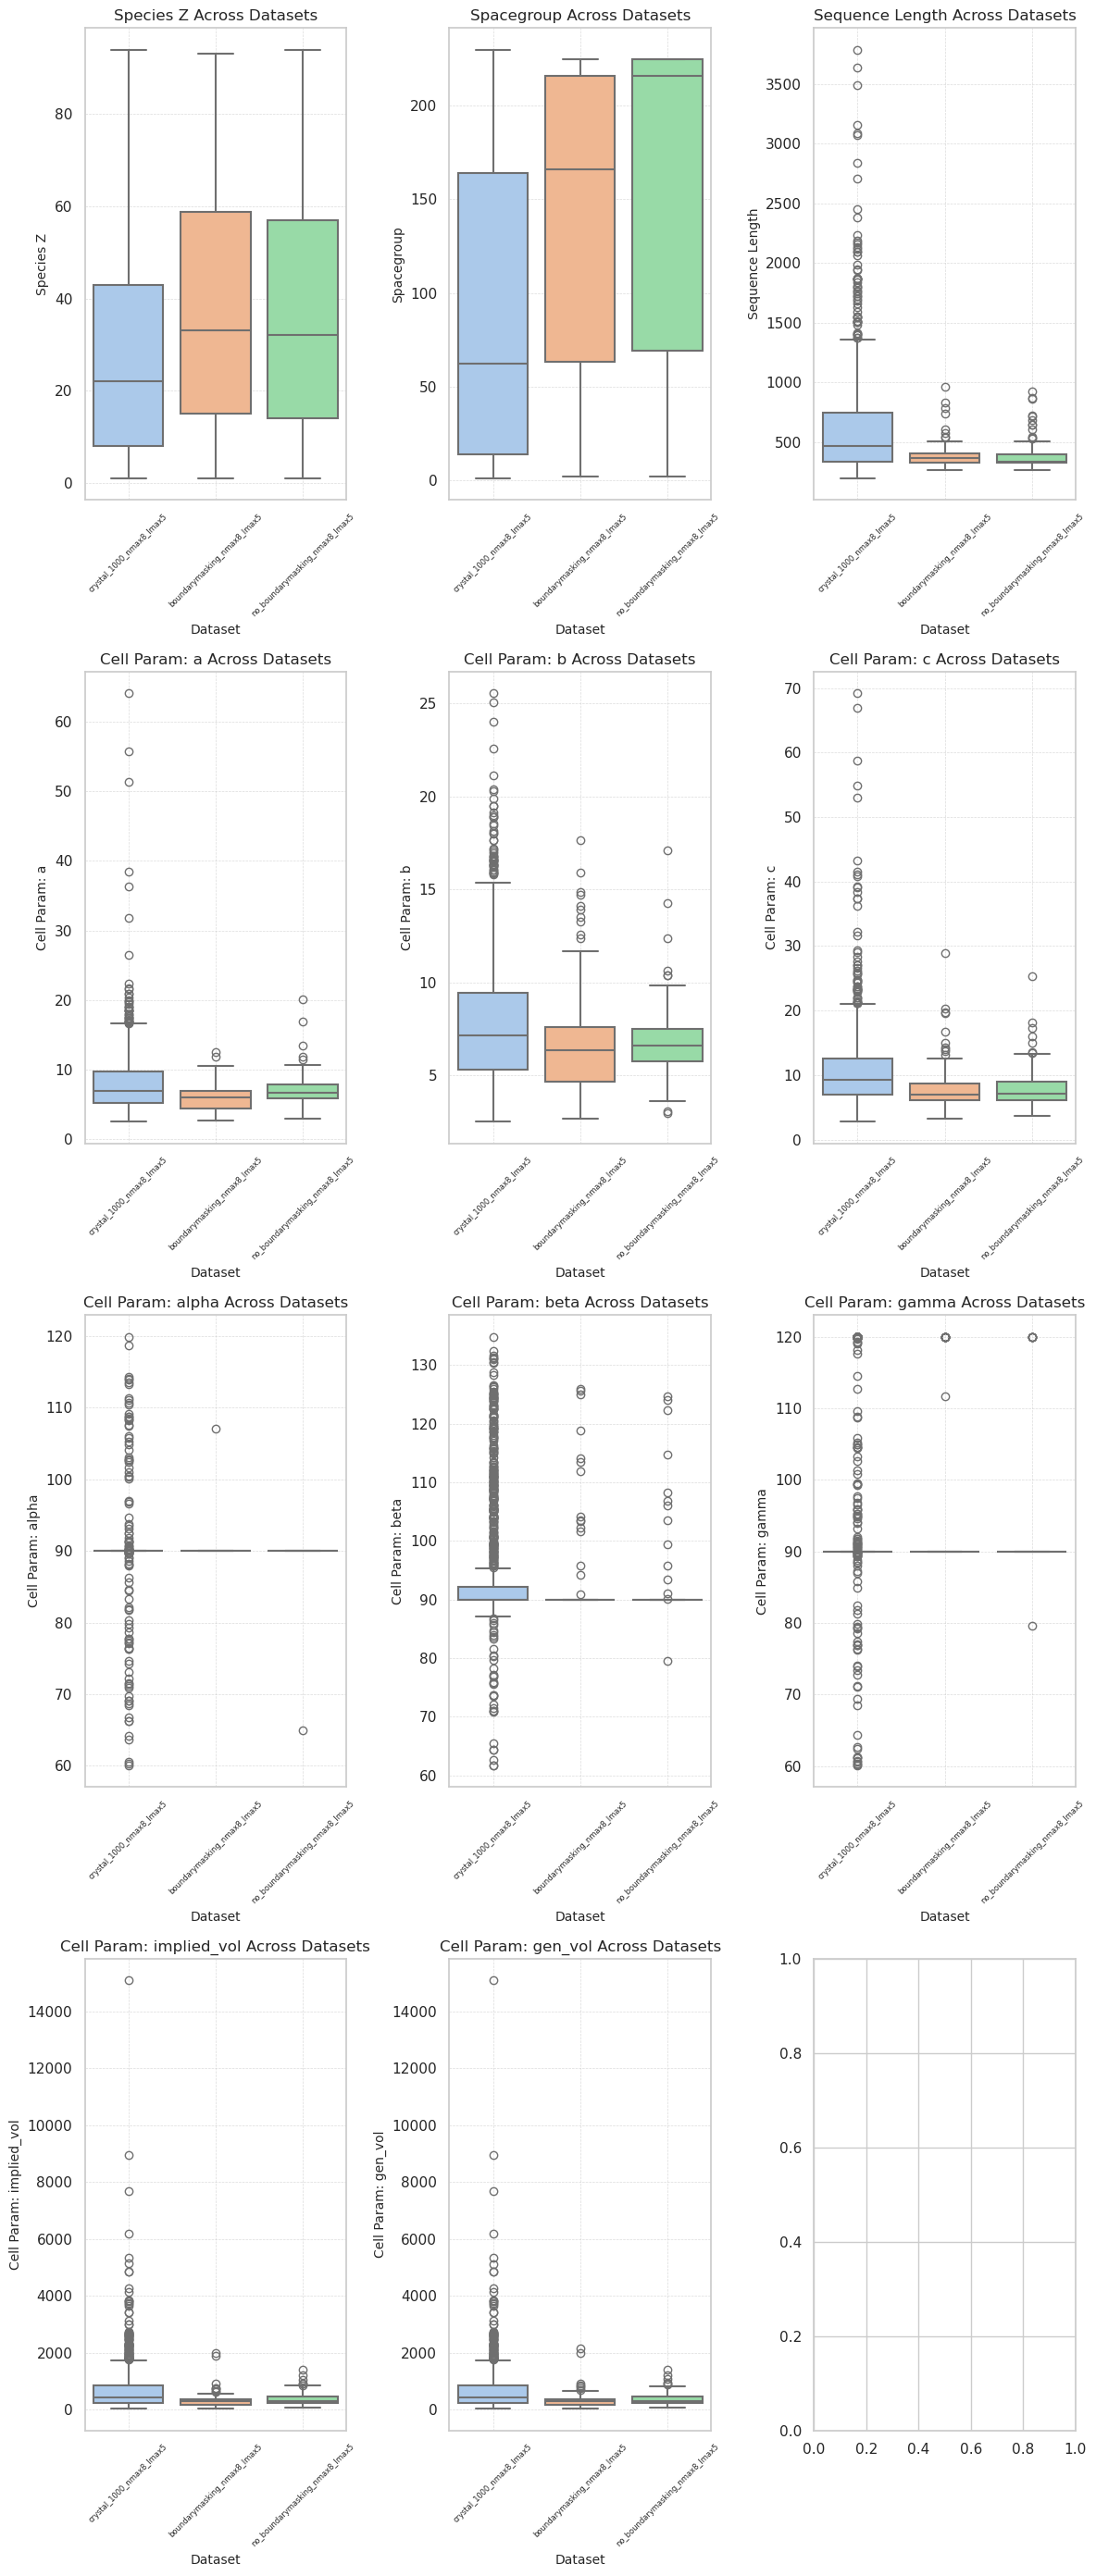

In [68]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Set the Seaborn theme for better aesthetics
sns.set_theme(style="whitegrid", palette="muted")

# Function to calculate summary statistics
def summary_statistics(data, param_name):
    summary = pd.DataFrame({
        'Mean': [np.mean(data)],
        'Median': [np.median(data)],
        'Std Dev': [np.std(data)],
        'Min': [np.min(data)],
        'Max': [np.max(data)],
        'Range': [np.ptp(data)],
        'Skewness': [stats.skew(data)],
        'Kurtosis': [stats.kurtosis(data)]
    })
    print(f"Summary Statistics for {param_name}:")
    print(summary)
    return summary

# Function to plot boxplots for different datasets in subplots
def plot_boxplot_subplots(params_data_dict, params_labels_dict, n_rows=4, n_cols=3, figsize=(12, 28)):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()  # Flatten axes for easy indexing
    
    for idx, param in enumerate(params_data_dict.keys()):
        param_data = params_data_dict[param]
        dataset_labels = params_labels_dict[param]
        
        # Create a dataframe for plotting with Seaborn
        df = pd.DataFrame({
            param: param_data,
            'Dataset': dataset_labels
        })
        
        # Assign the x variable to hue and set legend=False as per Seaborn's future behavior
        sns.boxplot(x='Dataset', y=param, data=df, hue='Dataset', palette='pastel', linewidth=1.5, dodge=False, ax=axes[idx], legend=False)
        
        axes[idx].set_title(f'{param} Across Datasets')
        axes[idx].set_ylabel(param, fontsize=10)
        axes[idx].set_xlabel('Dataset', fontsize=10)
        axes[idx].tick_params(axis='x', rotation=45, labelsize=6)
        axes[idx].tick_params(axis='y')
        
        # Customize grid lines for a cleaner look
        axes[idx].grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
    plt.tight_layout()
    plt.show()

# Prepare the data for each parameter
params_data_dict = {
    'Species Z': all_species,
    'Spacegroup': all_spacegroups,
    'Sequence Length': all_seq_len,
    'Cell Param: a': all_cell_params['a'],
    'Cell Param: b': all_cell_params['b'],
    'Cell Param: c': all_cell_params['c'],
    'Cell Param: alpha': all_cell_params['alpha'],
    'Cell Param: beta': all_cell_params['beta'],
    'Cell Param: gamma': all_cell_params['gamma'],
    'Cell Param: implied_vol': all_cell_params['implied_vol'],
    'Cell Param: gen_vol': all_cell_params['gen_vol']
}

params_labels_dict = {
    'Species Z': dataset_labels_species,
    'Spacegroup': dataset_labels_spacegroups,
    'Sequence Length': dataset_labels_seq_len,
    'Cell Param: a': dataset_labels_cell_params['a'],
    'Cell Param: b': dataset_labels_cell_params['b'],
    'Cell Param: c': dataset_labels_cell_params['c'],
    'Cell Param: alpha': dataset_labels_cell_params['alpha'],
    'Cell Param: beta': dataset_labels_cell_params['beta'],
    'Cell Param: gamma': dataset_labels_cell_params['gamma'],
    'Cell Param: implied_vol': dataset_labels_cell_params['implied_vol'],
    'Cell Param: gen_vol': dataset_labels_cell_params['gen_vol']
}

# Plot all boxplots in subplots
plot_boxplot_subplots(params_data_dict, params_labels_dict)


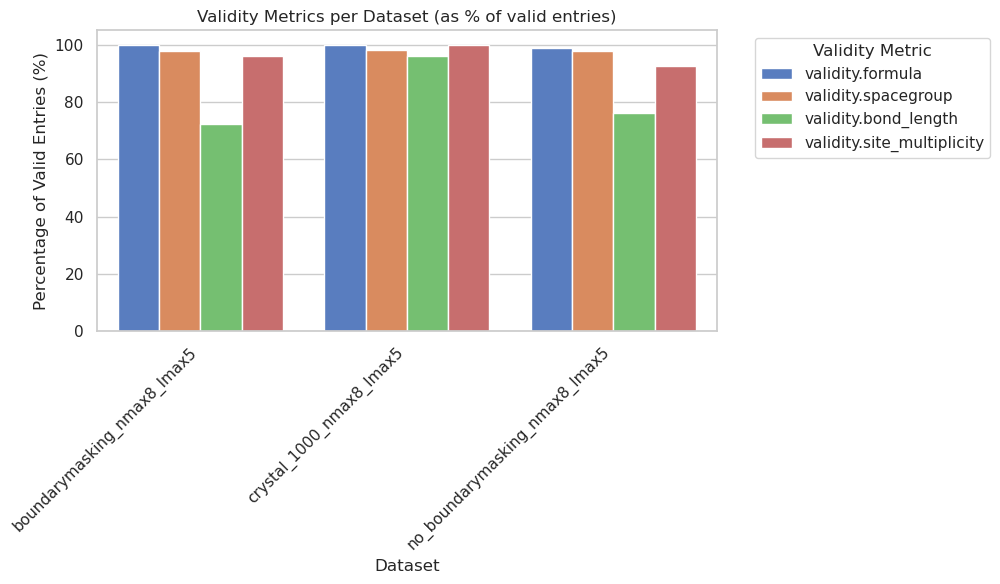

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you already have the dataframe loaded
# Example: df = pd.read_csv('your_dataframe.csv')

# Function to calculate statistics and create a seaborn plot
def plot_validity_stats(df):
    # Ensure the validity columns are boolean
    validity_columns = ['validity.formula', 'validity.spacegroup', 'validity.bond_length', 'validity.site_multiplicity']
    df[validity_columns] = df[validity_columns].astype(bool)
    
    # Group by 'dataset' and calculate mean for each validity metric
    grouped = df.groupby('dataset_name')[validity_columns].mean() * 100  # Convert to percentage
    
    # Reset the index to make it easier to plot with seaborn
    grouped = grouped.reset_index().melt(id_vars='dataset_name', var_name='validity_metric', value_name='percentage_valid')
    
    # Create a seaborn bar plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='dataset_name', y='percentage_valid', hue='validity_metric', data=grouped)
    
    plt.title("Validity Metrics per Dataset (as % of valid entries)")
    plt.ylabel("Percentage of Valid Entries (%)")
    plt.xlabel("Dataset")
    plt.legend(title="Validity Metric", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # Show the plot
    plt.show()

# Example call to the function
plot_validity_stats(df)


Processing files:   0%|          | 0/3 [00:00<?, ?it/s]

SOAP summary features shape: (1193, 4)
SOAP full features shape: (1193, 18360)
ACSF summary features shape: (1193, 4)
ACSF full features shape: (1193, 85)
XRD summary features shape: (1193, 4)
XRD full features shape: (1193, 1000)
Performing PCA on SOAP_Summary features...
Removing outliers from SOAP_Summary reduced features...
Samples before outlier removal: 1193
Samples after outlier removal: 1135
Performing PCA on SOAP_Full features...
Removing outliers from SOAP_Full reduced features...
Samples before outlier removal: 1193
Samples after outlier removal: 1160
Performing PCA on ACSF_Summary features...
Removing outliers from ACSF_Summary reduced features...
Samples before outlier removal: 1193
Samples after outlier removal: 1105
Performing PCA on ACSF_Full features...
Removing outliers from ACSF_Full reduced features...
Samples before outlier removal: 1193
Samples after outlier removal: 1081
Performing PCA on XRD_Summary features...
Removing outliers from XRD_Summary reduced features

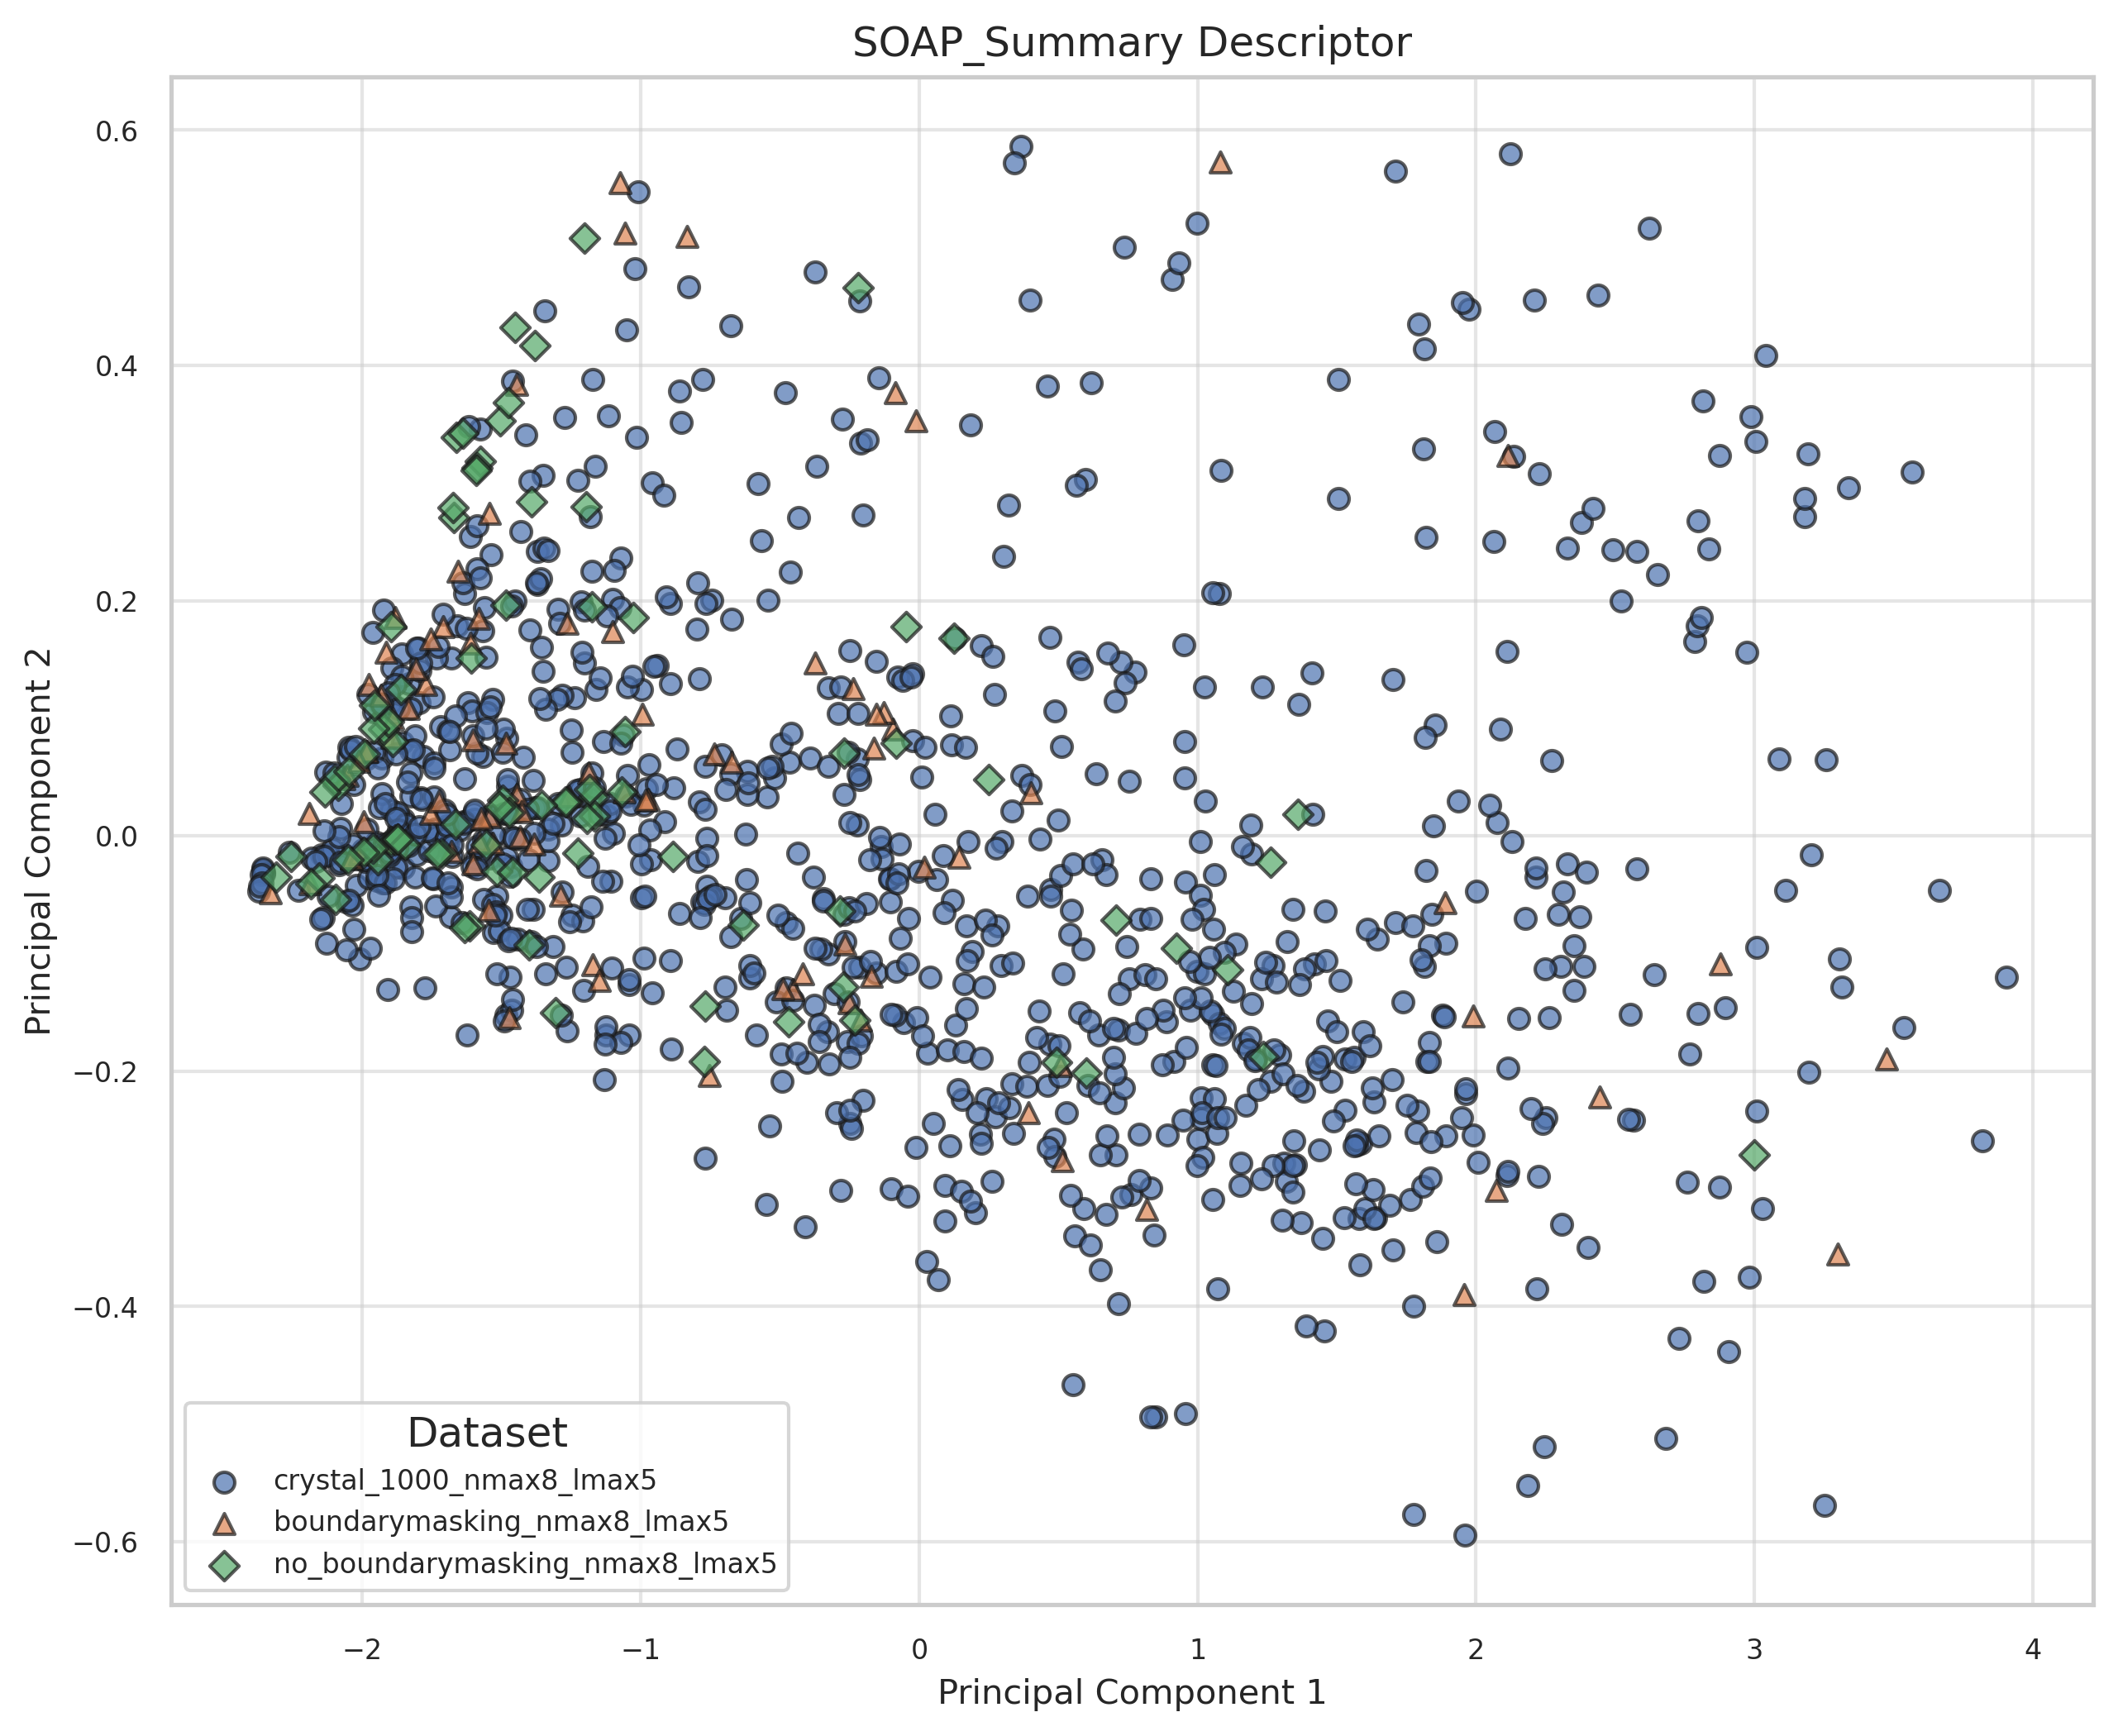

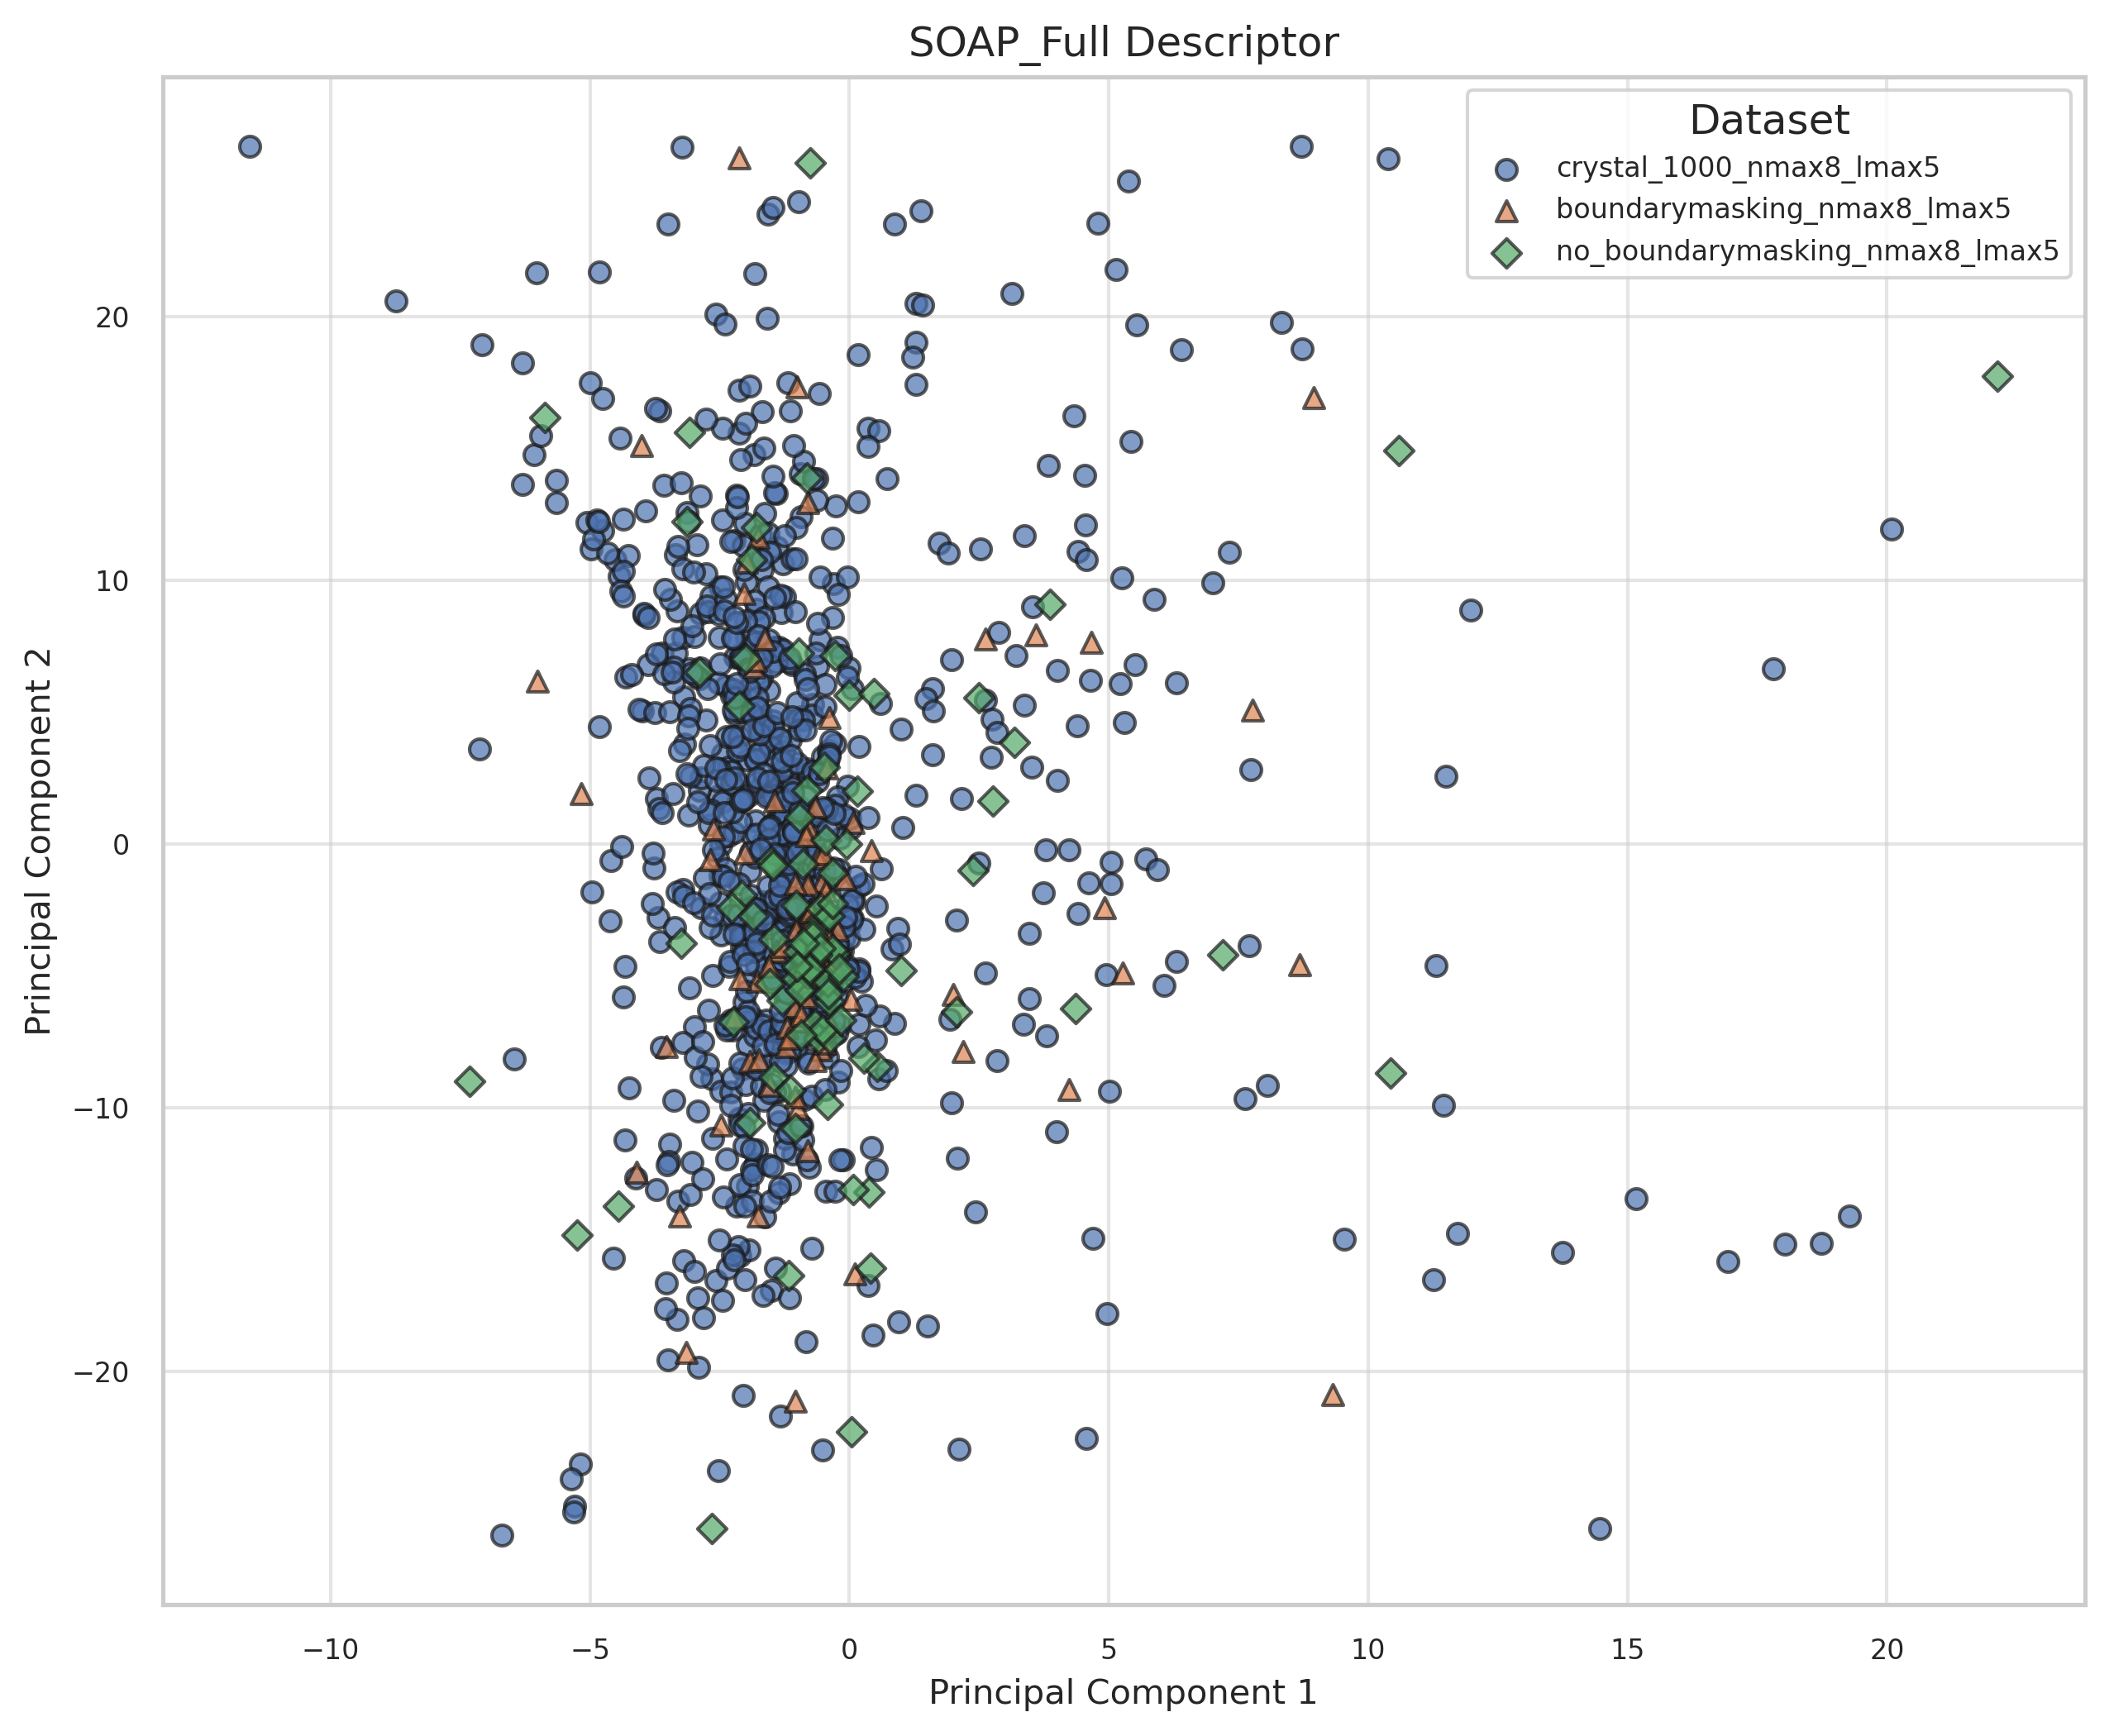

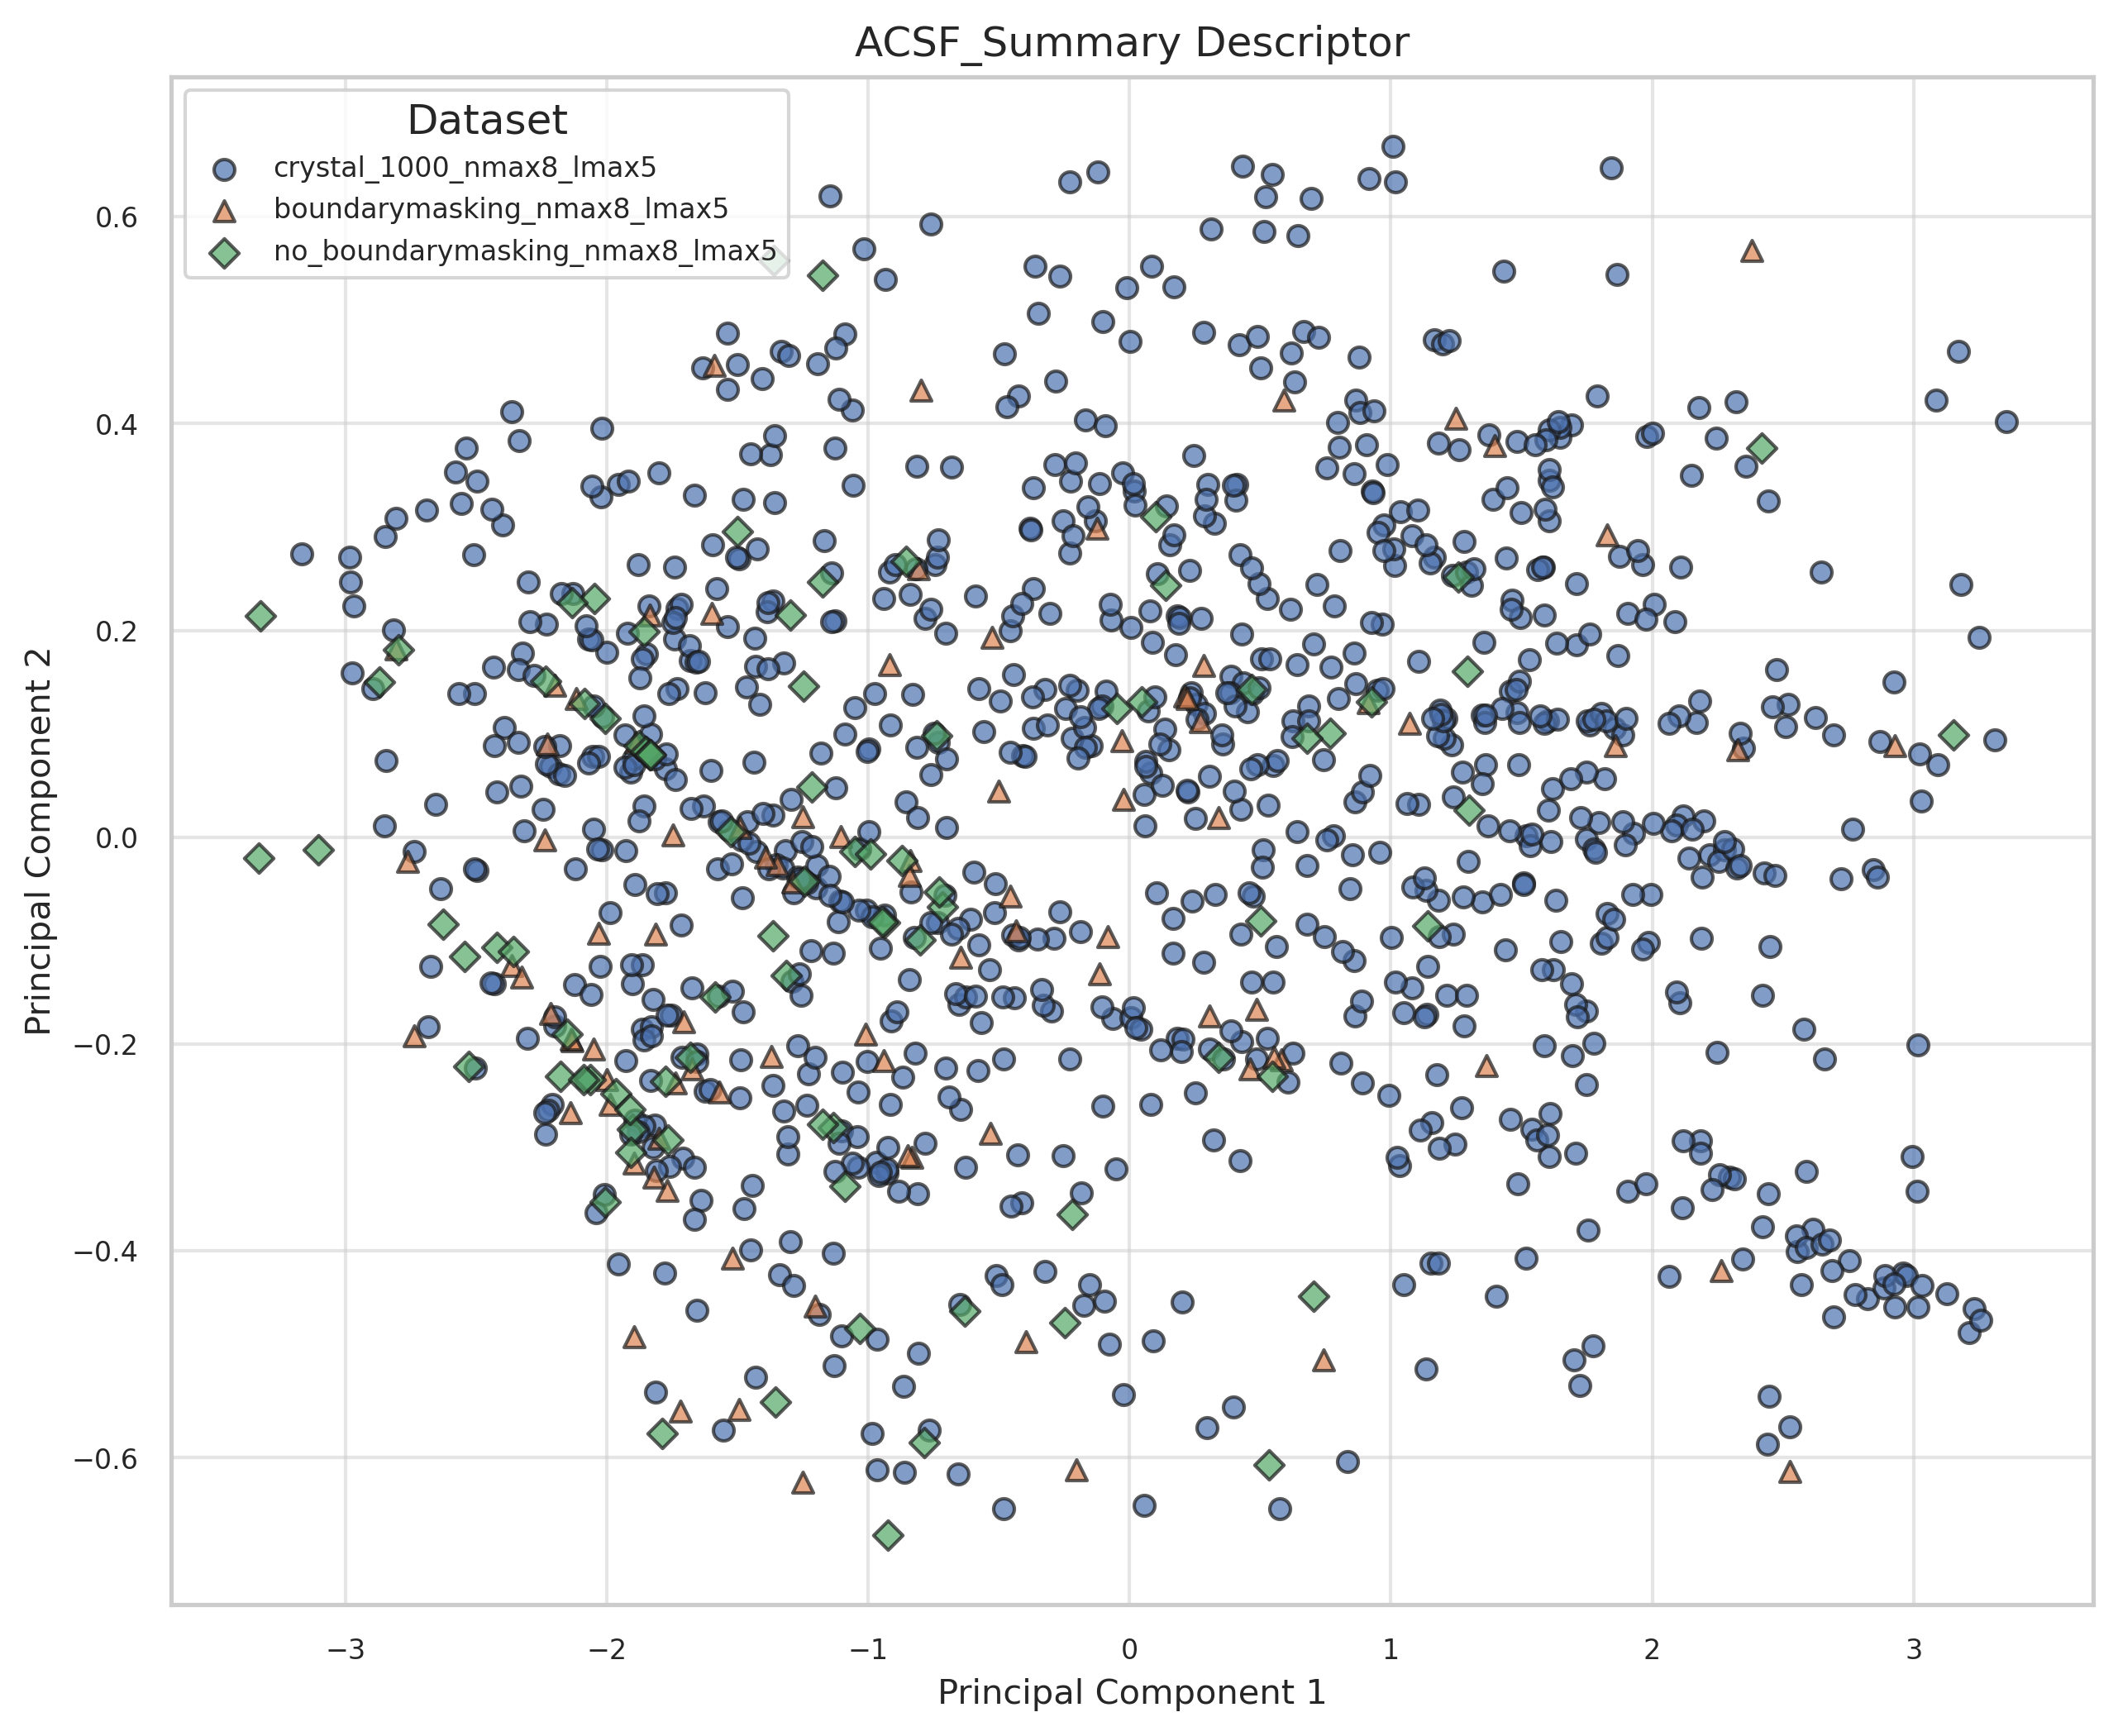

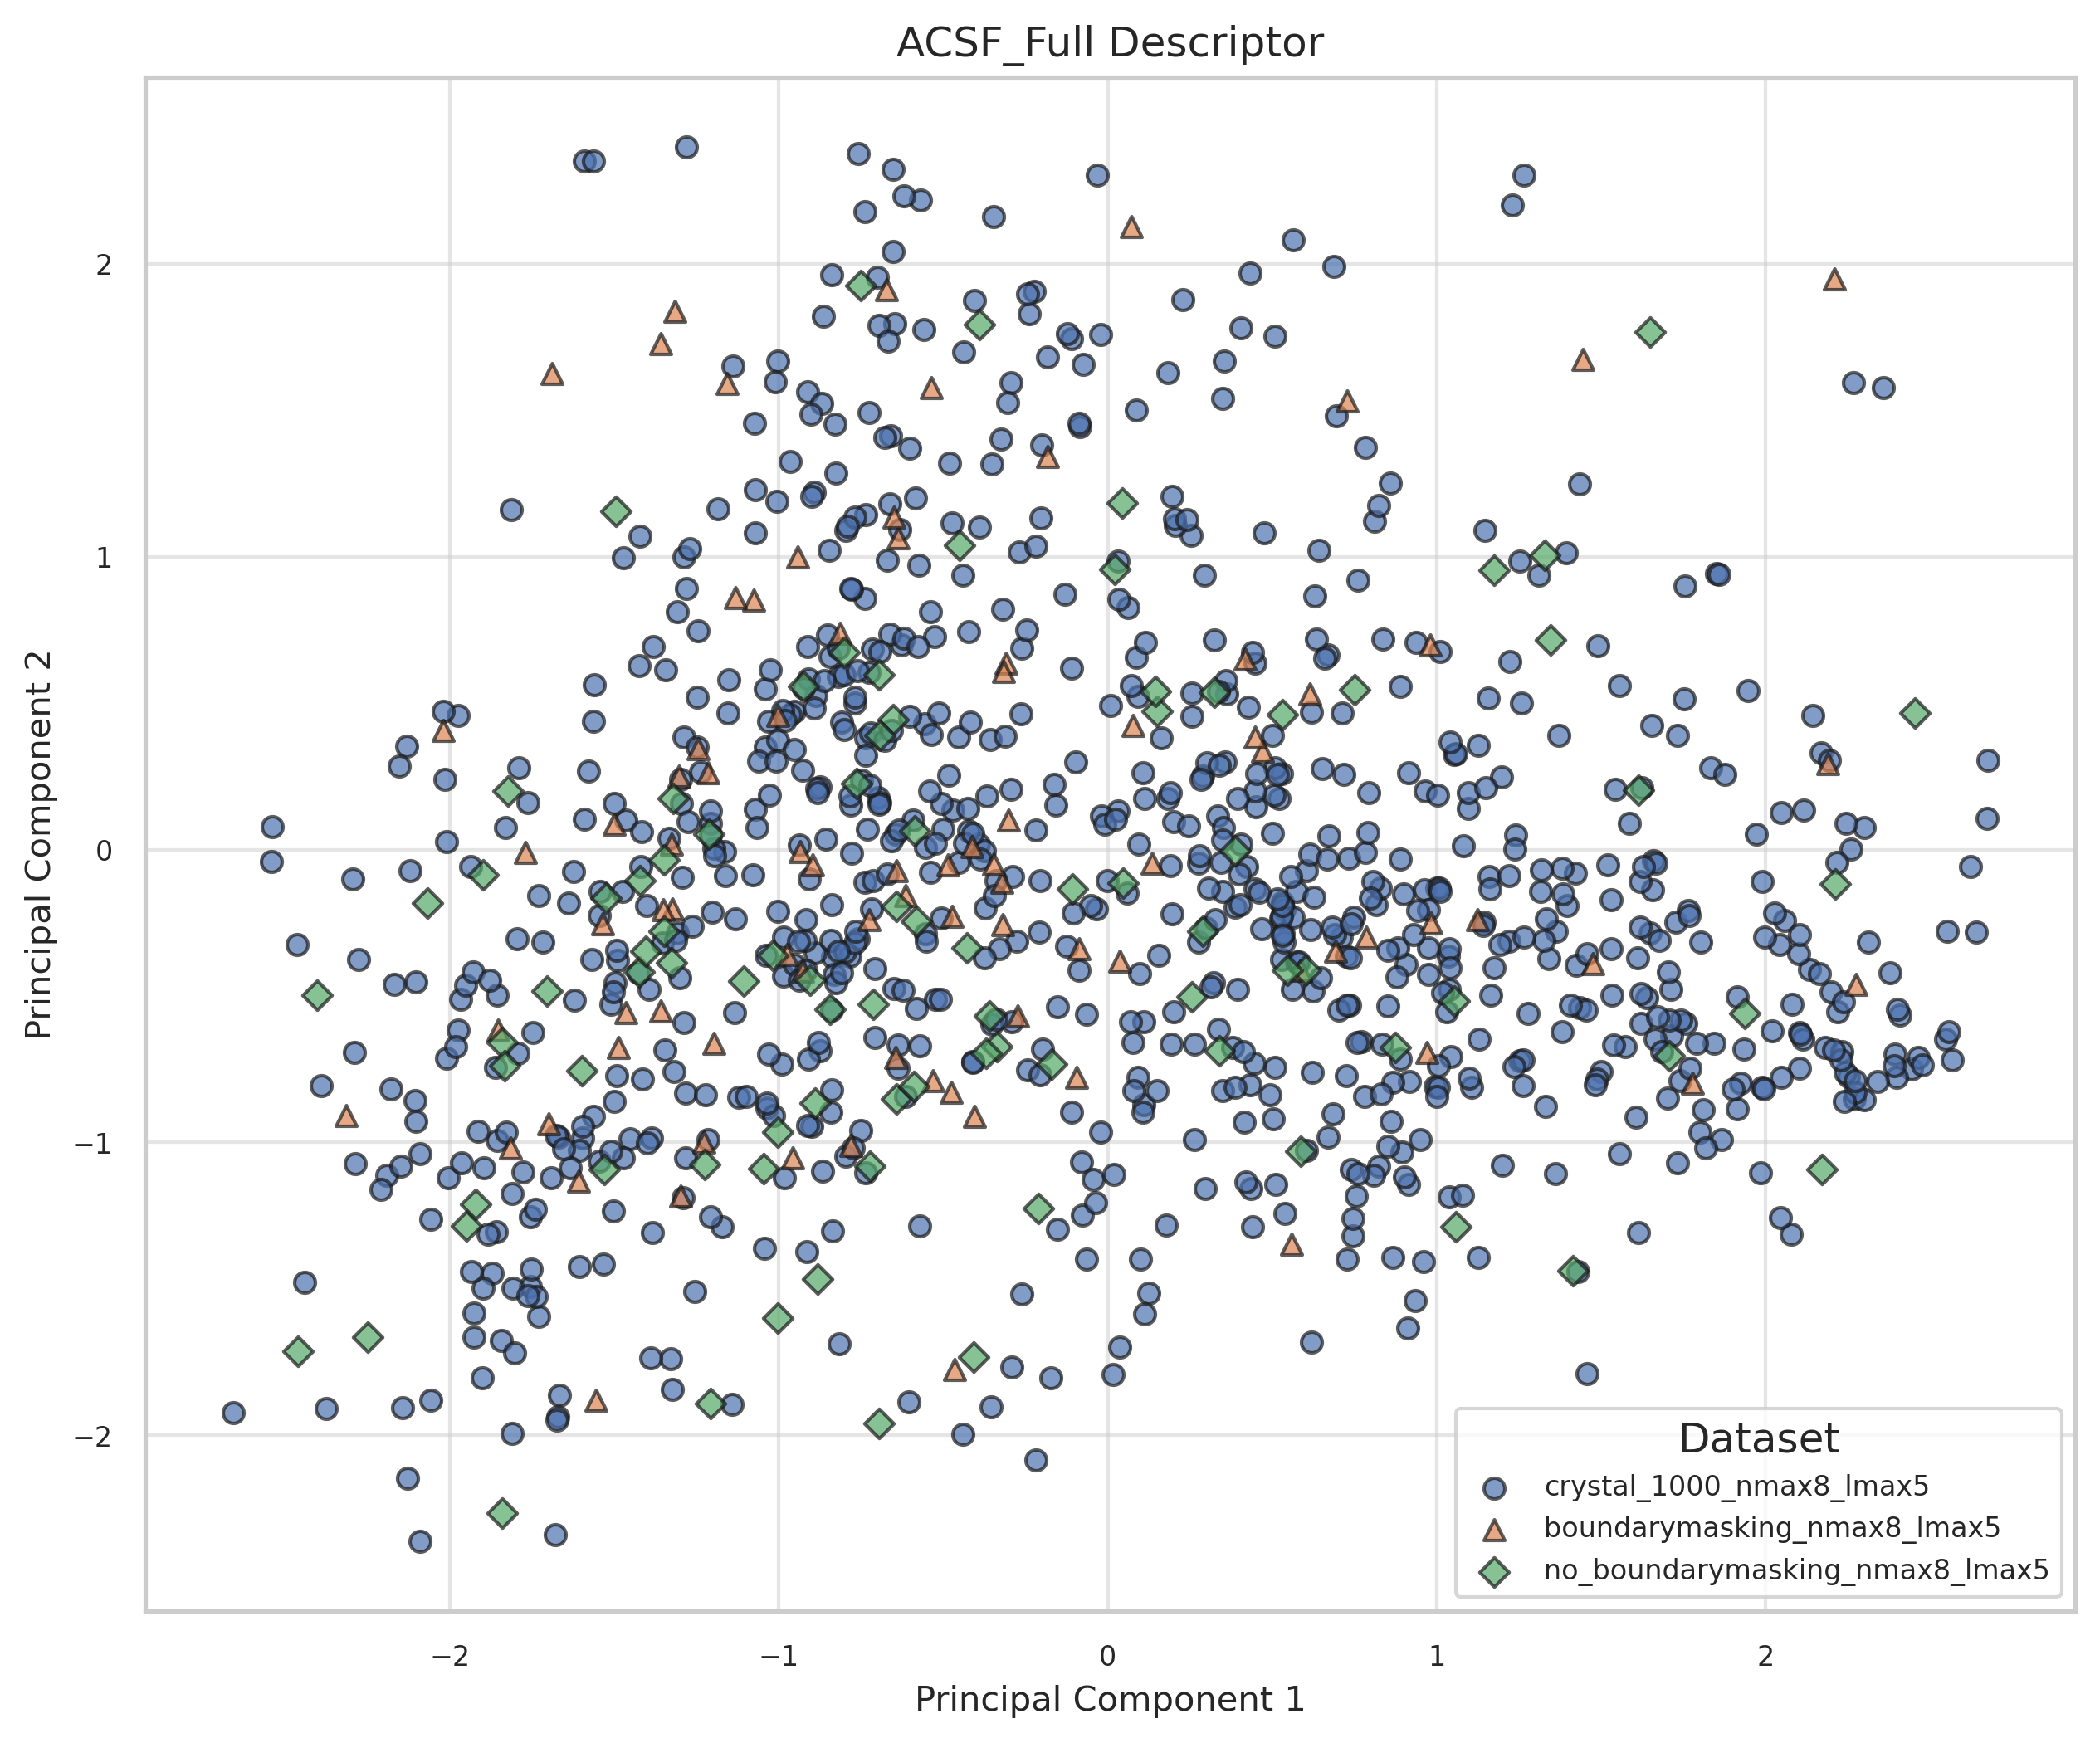

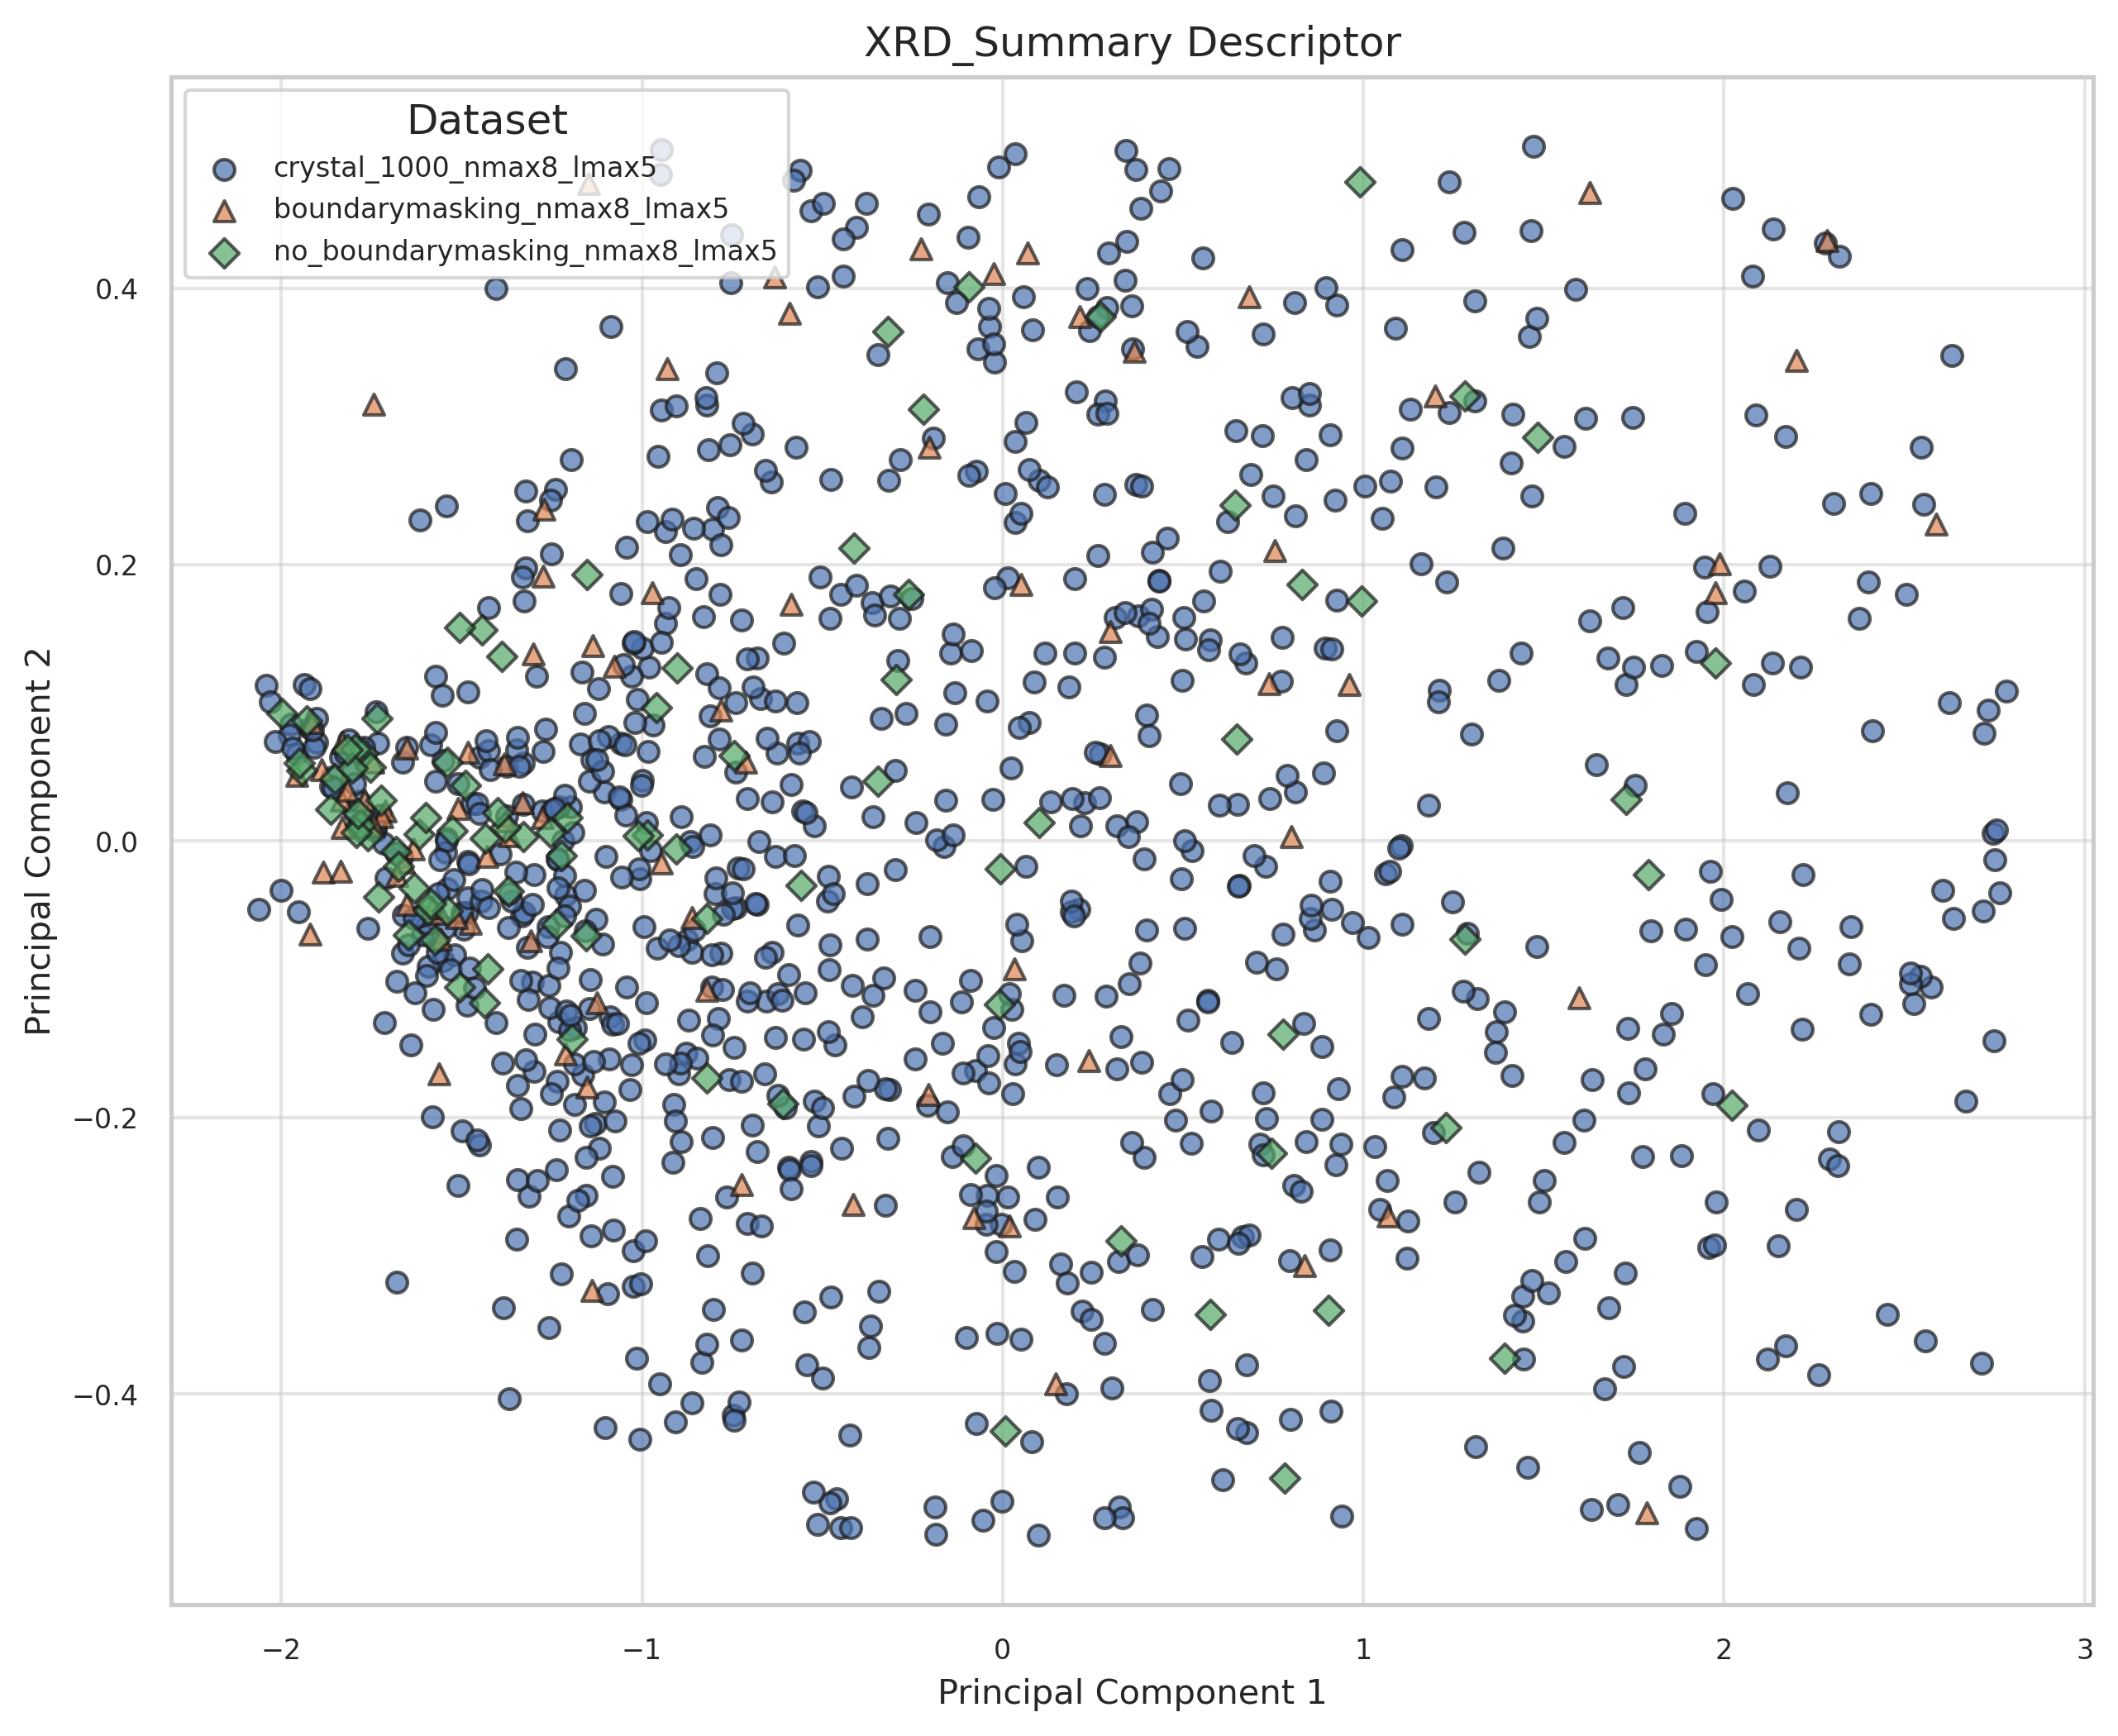

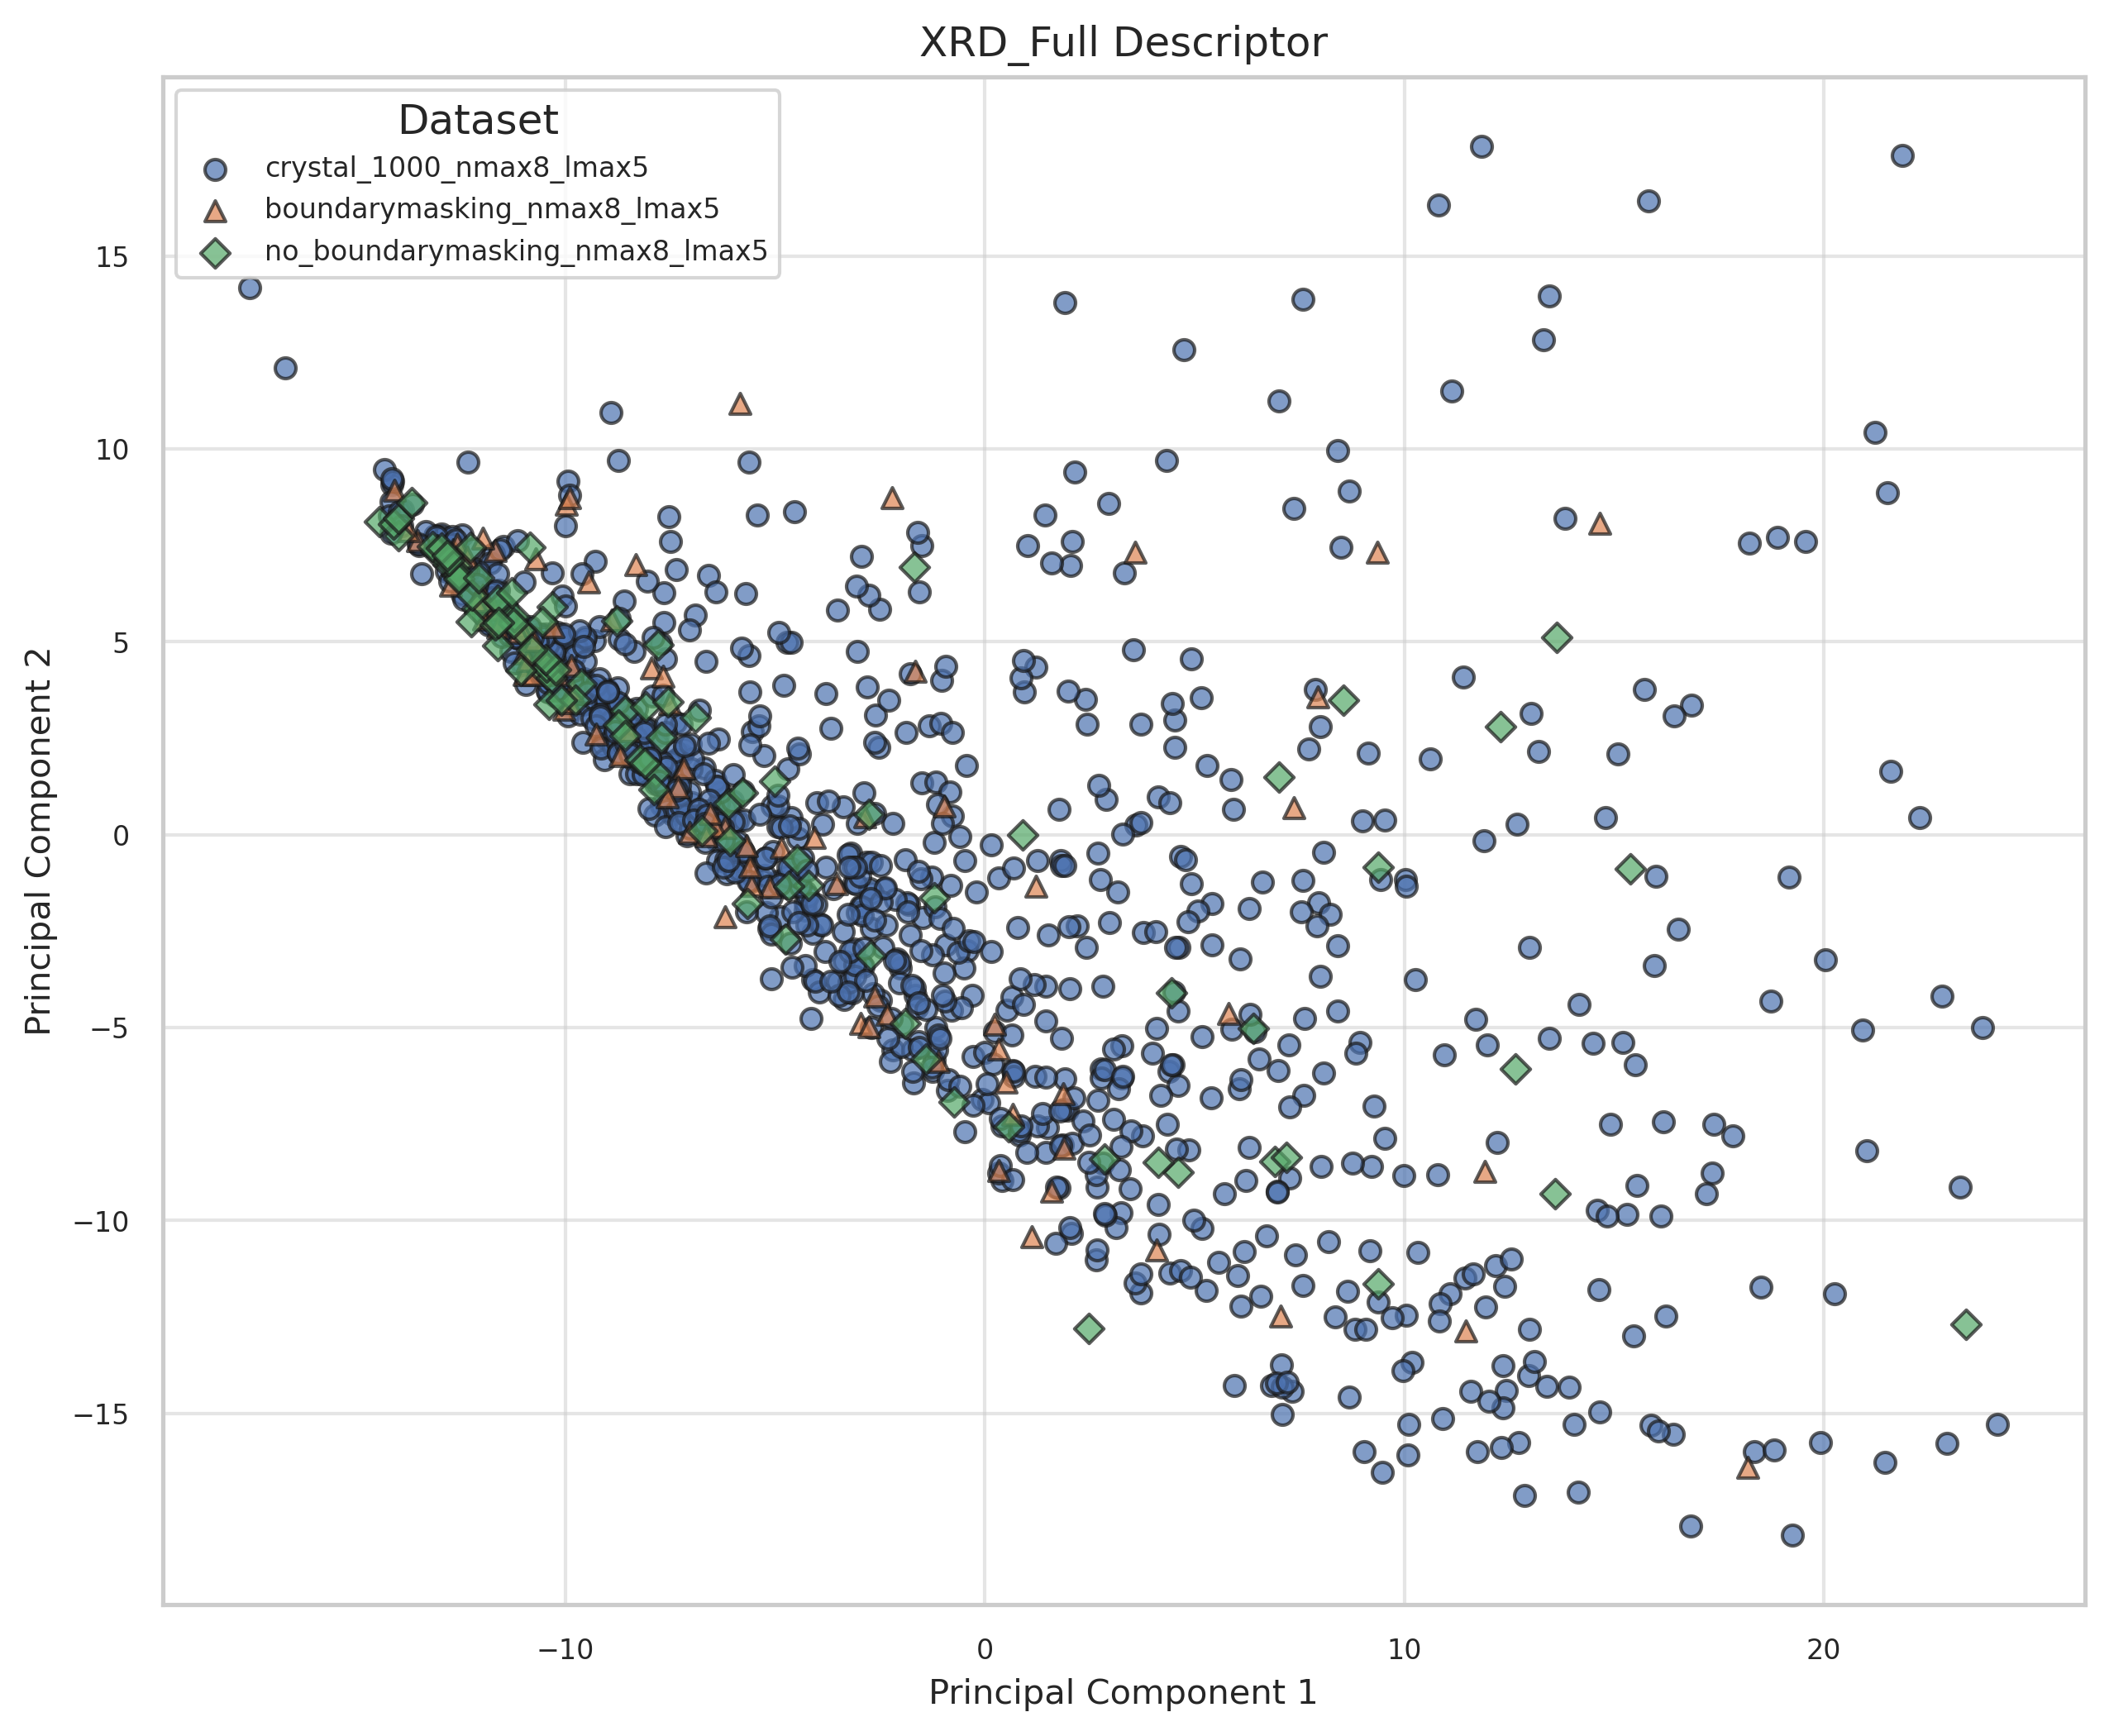

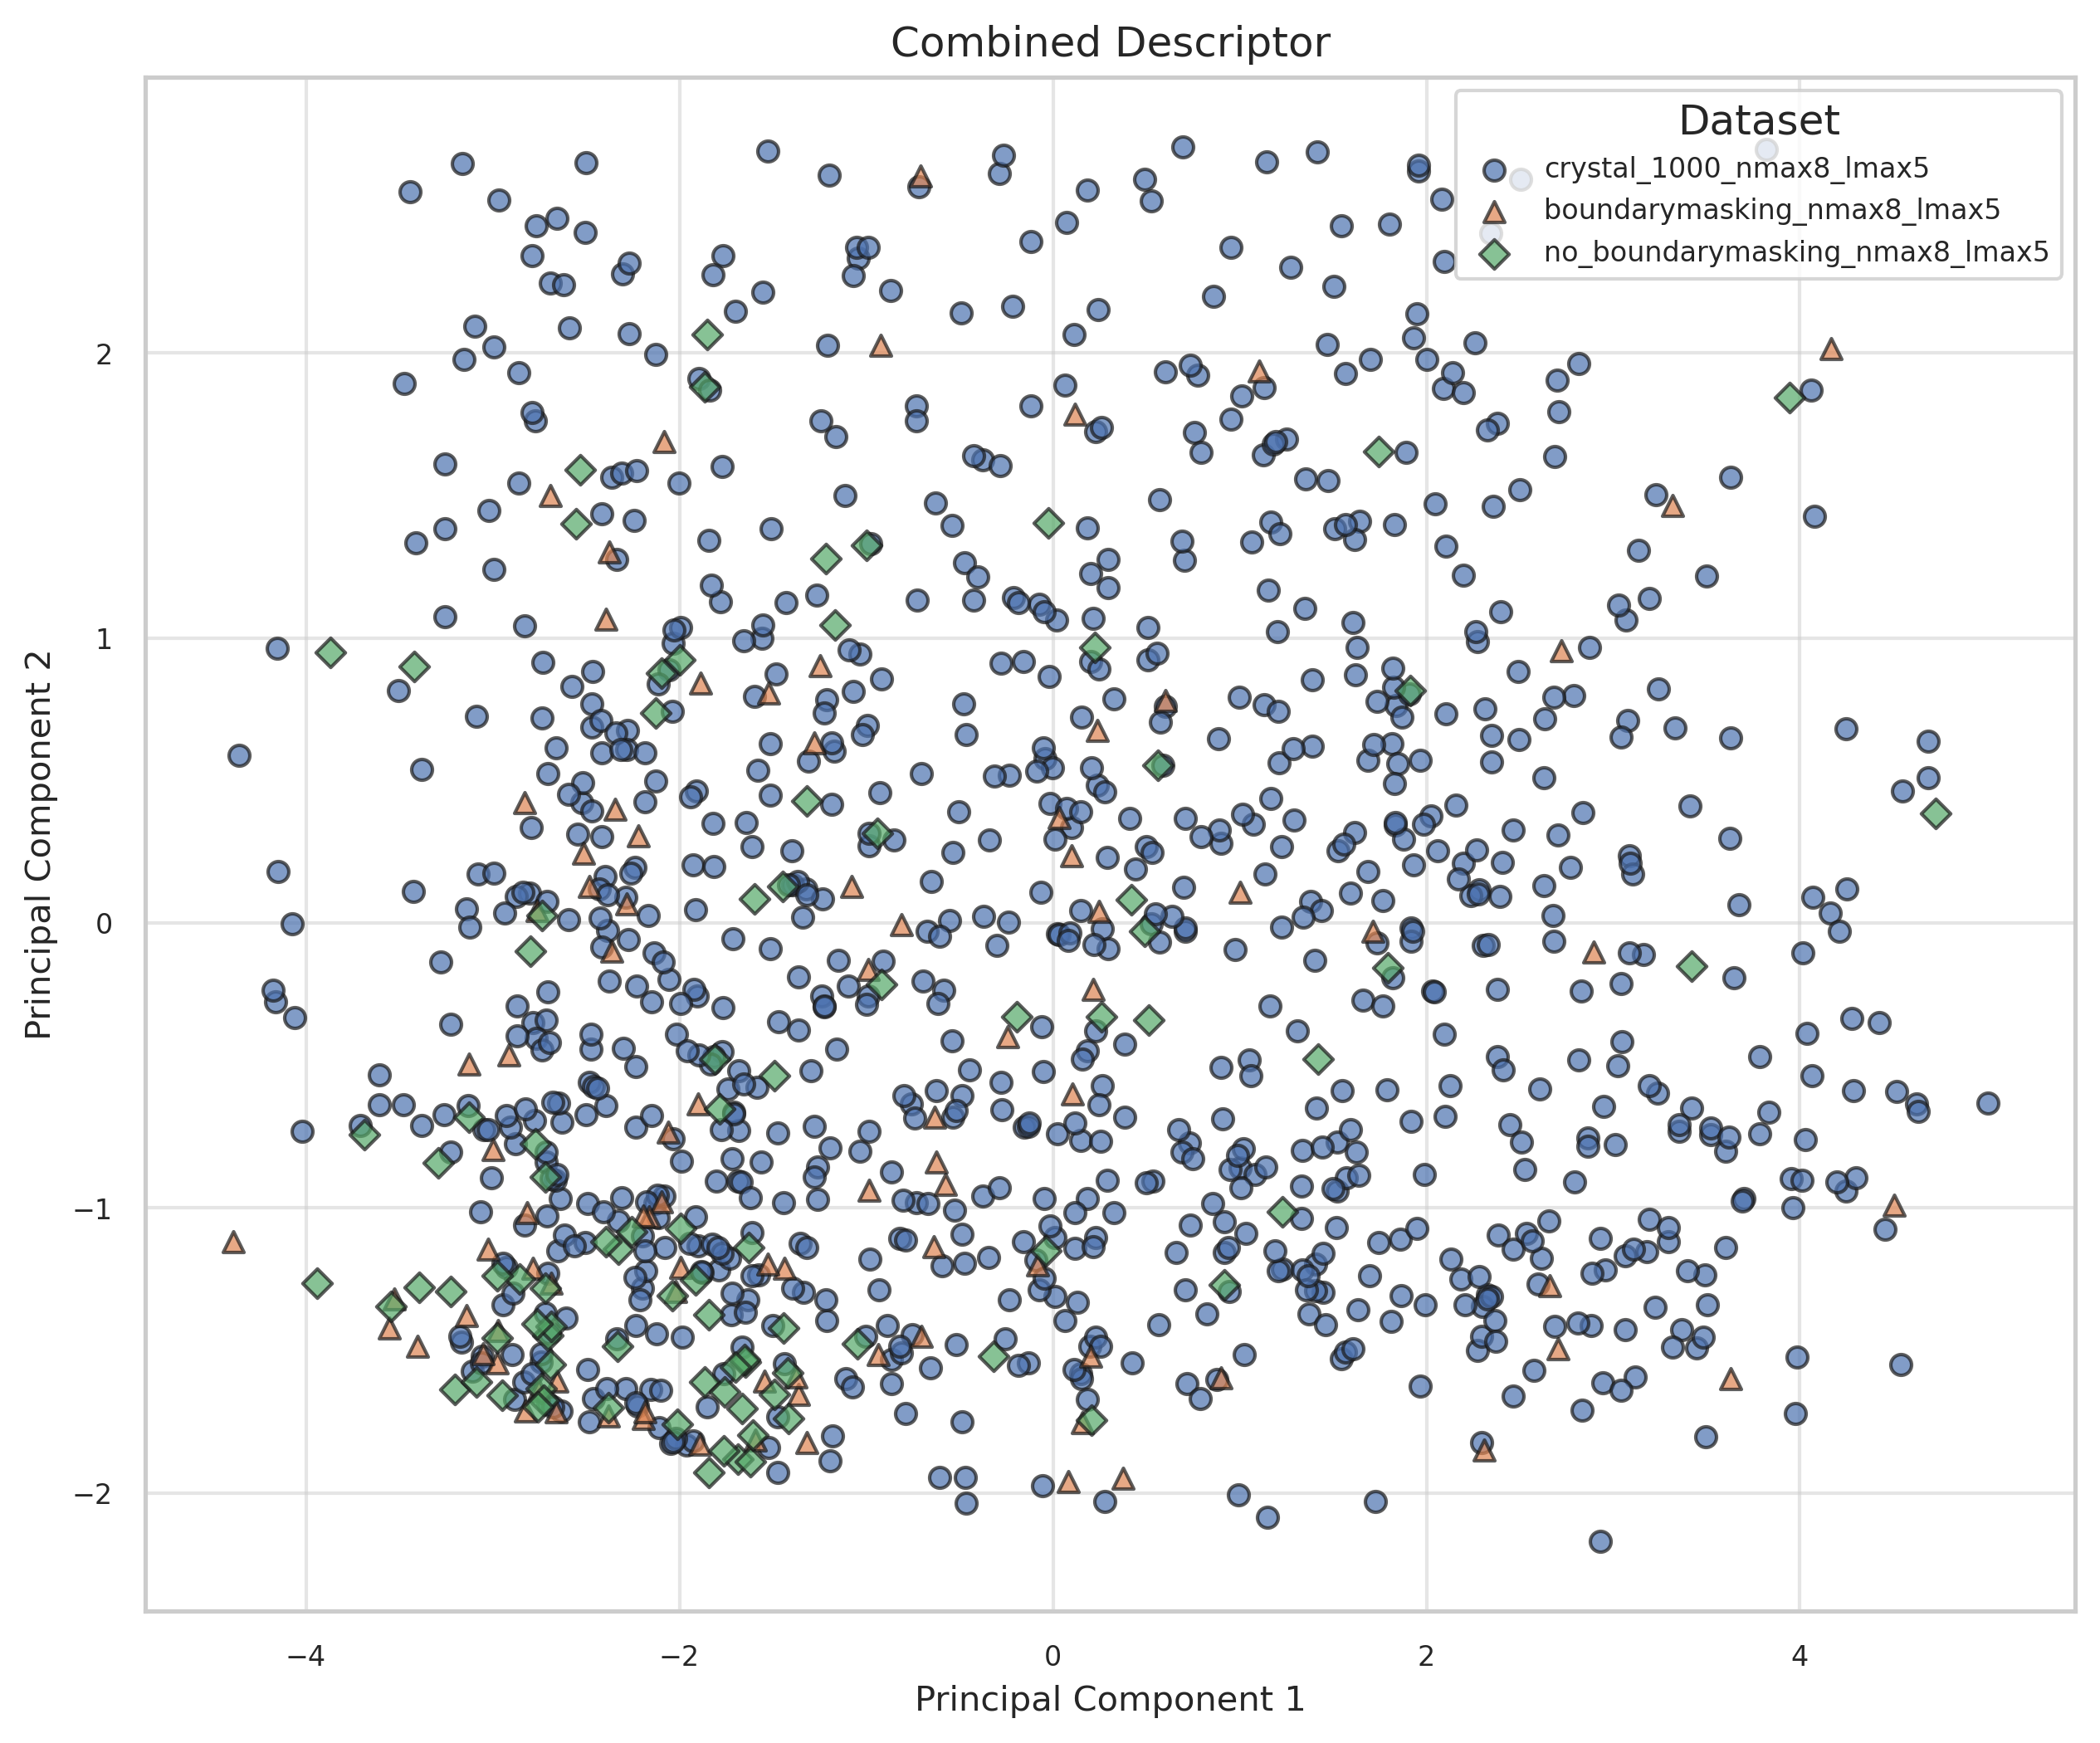

In [71]:
# Define file paths and options
# Replace the following list with your actual .eval file paths
file_list = [
    '../nomodel/crystal_1k/nmax8_lmax5/crystal_1000_nmax8_lmax5.eval',
    '../cross-contamination/deciferdataset_experiment/boundarymasking/boundarymasking_nmax8_lmax5.eval',
    '../cross-contamination/deciferdataset_experiment/no_boundarymasking/no_boundarymasking_nmax8_lmax5.eval',
    # Add more file paths as needed
]

# Options
remove_outliers = True  # Set to True if you want to remove outliers
outlier_method = 'zscore'  # 'zscore' or 'iqr'
outlier_thresh = 2.0  # Threshold for outlier detection

# Load and extract relevant features
df = load_and_extract_features(file_list)

# Extract individual and combined feature matrices
feature_dict, df_filtered = get_feature_matrices(df)

# Initialize dictionaries to store reduced features and filtered DataFrames
reduced_features_dict = {}
df_filtered_dict = {}

for key in feature_dict:
    print(f"Performing PCA on {key} features...")
    reduced_features, pca, scaler = perform_dimensionality_reduction(feature_dict[key], n_components=2)

    # Outlier removal after PCA
    if remove_outliers:
        print(f"Removing outliers from {key} reduced features...")
        mask = filter_outliers_on_reduced_features(
            reduced_features, method=outlier_method, thresh=outlier_thresh
        )
        print(f"Samples before outlier removal: {len(reduced_features)}")
        print(f"Samples after outlier removal: {np.sum(mask)}")

        if np.sum(mask) == 0:
            raise ValueError(f"No data left after outlier removal on {key} features.")

        # Filter reduced features and DataFrame
        reduced_features = reduced_features[mask]
        df_filtered_key = df_filtered.iloc[mask].reset_index(drop=True)
        df_filtered_dict[key] = df_filtered_key
    else:
        df_filtered_dict[key] = df_filtered.copy()

    # Store the filtered reduced features
    reduced_features_dict[key] = reduced_features
    
# Visualize the samples
visualize_samples(
    reduced_features_dict,
    df_filtered_dict,
)